LSTM数据格式（示例）：多时间点数据（例如一个患者多行，带时间序列）

## Step 1: Data Cleaning

- 1.1 pesticide poisoning

- 1.1.1 acute organophosphate poisoning

In [ ]:
import pandas as pd 
import numpy as np
import copy
import torch
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import StandardScaler, LabelEncoder

### Data path
search_path = "/home/mailiyi/Poisoning_Prediction/rawdata/"
# 1. Read data
file_path = search_path + "Acute_Organophosphate_Poisoning.xlsx"
df = pd.read_excel(file_path)

# 2. Remove empty columns
df = df.drop(columns=[col for col in df.columns if df[col].isna().all()])
print(f"Data reading completed, data dimensions: {df.shape}")

# 3. Convert time column
df["检验时间"] = pd.to_datetime(df["检验时间"], errors="coerce")
# Sort
df = df.sort_values(["住院号", "检验时间"]).reset_index(drop=True)
# Remove duplicates for the same hospital ID and time point, keep the first record
df = df.drop_duplicates(subset=["住院号", "检验时间"], keep="first").reset_index(drop=True)
print(f"Data reading completed, data dimensions: {df.shape}")

# # 4. Label columns
# df["Outcome_other"] = df["转归"].apply(lambda x: 1 if "死亡" in str(x) else 0)  ## Whether deceased
# df["Outcome"] = df["转归"].apply(lambda x: 1 if ("死亡" in str(x) or "未愈" in str(x)) else 0)  ## Whether not recovered

# # Count the 0/1 distribution of each label
# print("Outcome_other distribution:")
# print(df["Outcome_other"].value_counts())

# print("\nOutcome distribution:")
# print(df["Outcome"].value_counts())

## 4. Label columns: Match label columns with cleaned data
df_final_label = pd.read_excel('/home/mailiyi/Poisoning_Prediction/rawdata_中毒数据_patient_last_1114.xlsx')
## Poisoning type label mapping
type_mapping = {1:'Industrial Poisoning', 2:'Drug Poisoning', 3:'Pesticide Poisoning', 4:'Alcohol Poisoning'}
df_final_label = df_final_label[['Hospital ID','Type of Poisoning', '居住地（1农村 2城市）','Outcome_other', 'Outcome']]
df_final_label['Type of Poisoning'] = df_final_label['Type of Poisoning'].map(type_mapping) ## For easier data verification
df_final_label = df_final_label.rename(columns={'Hospital ID': '住院号'})

df = df.merge(df_final_label, on='住院号', how='left')
print(f"Data label merging completed, data dimensions: {df.shape}")

df_Pesticide_1 = copy.deepcopy(df)


数据读取完成，数据维度：(5497, 54)
数据读取完成，数据维度：(530, 54)
数据标签合并完成，数据维度：(530, 58)


In [ ]:
# Remove duplicates based on the hospital ID (keep only one record per patient)
df_unique = df_Pesticide_1.drop_duplicates(subset=['住院号']).reset_index(drop=True)

# Count the distribution of Outcome_other and Outcome
print("\nOutcome_other Distribution:")
print(df_unique["Outcome_other"].value_counts(dropna=False))

print("\nOutcome Distribution:")
print(df_unique["Outcome"].value_counts(dropna=False))

# (Optional) Output summary table
summary = pd.DataFrame({
    "Count": df_unique["Outcome_other"].value_counts(),
    "Percentage (%)": (df_unique["Outcome_other"].value_counts(normalize=True) * 100).round(2)
})
print("\nOutcome_other (Mortality) Summary:")
print(summary)

# (Optional) Output summary table
summary = pd.DataFrame({
    "Count": df_unique["Outcome"].value_counts(),
    "Percentage (%)": (df_unique["Outcome"].value_counts(normalize=True) * 100).round(2)
})
print("\nOutcome (Not Cured) Summary:")
print(summary)



Outcome_other 分布：
Outcome_other
0    96
1     8
Name: count, dtype: int64

Outcome 分布：
Outcome
0    81
1    23
Name: count, dtype: int64

Outcome_other (是否死亡) 统计汇总：
               数量  比例(%)
Outcome_other           
0              96  92.31
1               8   7.69

Outcome (是否未愈) 统计汇总：
         数量  比例(%)
Outcome           
0        81  77.88
1        23  22.12


- 1.1.2 Paraquat and diquat

In [ ]:
import pandas as pd 
import numpy as np
import copy
import torch
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import StandardScaler, LabelEncoder

### Data path
search_path = "/home/mailiyi/Poisoning_Prediction/rawdata/"
# 1. Read data
file_path = search_path + "百草枯或敌草快.xlsx"
df = pd.read_excel(file_path)

# 2. Remove empty columns
df = df.drop(columns=[col for col in df.columns if df[col].isna().all()])
print(f"Data reading completed, data dimensions: {df.shape}")

# 3. Convert time column
df["检验时间"] = pd.to_datetime(df["检验时间"], errors="coerce")
# Sort
df = df.sort_values(["住院号", "检验时间"]).reset_index(drop=True)
# Remove duplicates for the same hospital ID and time point, keep the first record
df = df.drop_duplicates(subset=["住院号", "检验时间"], keep="first").reset_index(drop=True)
print(f"Data reading completed, data dimensions: {df.shape}")

# # 4. Label columns
# df["Outcome_other"] = df["转归"].apply(lambda x: 1 if "死亡" in str(x) else 0)  ## Whether deceased
# df["Outcome"] = df["转归"].apply(lambda x: 1 if ("死亡" in str(x) or "未愈" in str(x)) else 0)  ## Whether not recovered

# # Count the 0/1 distribution of each label
# print("Outcome_other distribution:")
# print(df["Outcome_other"].value_counts())

# print("\nOutcome distribution:")
# print(df["Outcome"].value_counts())

## 4. Label columns: Match label columns with cleaned data
df_final_label = pd.read_excel('/home/mailiyi/Poisoning_Prediction/rawdata_中毒数据_patient_last_1114.xlsx')
## Poisoning type label mapping
type_mapping = {1:'Industrial Poisoning', 2:'Drug Poisoning', 3:'Pesticide Poisoning', 4:'Alcohol Poisoning'}
df_final_label = df_final_label[['Hospital ID','Type of Poisoning', '居住地（1农村 2城市）','Outcome_other', 'Outcome']]
df_final_label['Type of Poisoning'] = df_final_label['Type of Poisoning'].map(type_mapping) ## For easier data verification
df_final_label = df_final_label.rename(columns={'Hospital ID': '住院号'})

df = df.merge(df_final_label, on='住院号', how='left')
print(f"Data label merging completed, data dimensions: {df.shape}")

df_Pesticide_2 = copy.deepcopy(df)


数据读取完成，数据维度：(154, 38)
数据读取完成，数据维度：(154, 38)
数据标签合并完成，数据维度：(154, 42)


In [ ]:
# Remove duplicates based on the hospital ID (keep only one record per patient)
df_unique = df_Pesticide_2.drop_duplicates(subset=['住院号']).reset_index(drop=True)

# Count the distribution of Outcome_other and Outcome
print("\nOutcome_other Distribution:")
print(df_unique["Outcome_other"].value_counts(dropna=False))

print("\nOutcome Distribution:")
print(df_unique["Outcome"].value_counts(dropna=False))

# (Optional) Output summary table
summary = pd.DataFrame({
    "Count": df_unique["Outcome_other"].value_counts(),
    "Percentage (%)": (df_unique["Outcome_other"].value_counts(normalize=True) * 100).round(2)
})
print("\nOutcome_other (Mortality) Summary:")
print(summary)

# (Optional) Output summary table
summary = pd.DataFrame({
    "Count": df_unique["Outcome"].value_counts(),
    "Percentage (%)": (df_unique["Outcome"].value_counts(normalize=True) * 100).round(2)
})
print("\nOutcome (Not Cured) Summary:")
print(summary)



Outcome_other 分布：
Outcome_other
0    32
1    21
Name: count, dtype: int64

Outcome 分布：
Outcome
1    36
0    17
Name: count, dtype: int64

Outcome_other (是否死亡) 统计汇总：
               数量  比例(%)
Outcome_other           
0              32  60.38
1              21  39.62

Outcome (是否未愈) 统计汇总：
         数量  比例(%)
Outcome           
1        36  67.92
0        17  32.08


- 1.1.3 Combine two types of pesticides

In [11]:
import pandas as pd

df_Pesticide = pd.concat([df_Pesticide_1, df_Pesticide_2], axis=0, ignore_index=True)

In [ ]:
print('-------------------sheet:Paraquat, Diquat + Acute Organophosphate Poisoning-------------------')
# Remove duplicates based on the hospital ID (keep only one record per patient)
df_unique = df_Pesticide.drop_duplicates(subset=['住院号']).reset_index(drop=True)

# Count the distribution of Outcome_other and Outcome
print("\nOutcome_other Distribution:")
print(df_unique["Outcome_other"].value_counts(dropna=False))

print("\nOutcome Distribution:")
print(df_unique["Outcome"].value_counts(dropna=False))

# (Optional) Output summary table
summary = pd.DataFrame({
    "Count": df_unique["Outcome_other"].value_counts(),
    "Percentage (%)": (df_unique["Outcome_other"].value_counts(normalize=True) * 100).round(2)
})
print("\nOutcome_other (Mortality) Summary:")
print(summary)

# (Optional) Output summary table
summary = pd.DataFrame({
    "Count": df_unique["Outcome"].value_counts(),
    "Percentage (%)": (df_unique["Outcome"].value_counts(normalize=True) * 100).round(2)
})
print("\nOutcome (Not Cured) Summary:")
print(summary)


In [ ]:
# Statistical Type of Poisoning Distribution
print("\nType of Poisoning 分布：")
print(df_unique["Type of Poisoning"].value_counts(dropna=False))


Type of Poisoning 分布：
Type of Poisoning
农药中毒    157
Name: count, dtype: int64


- 1.2 drug poisoning

In [ ]:
import pandas as pd 
import numpy as np
import copy
import torch
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import StandardScaler, LabelEncoder

### Data path
search_path = "/home/mailiyi/Poisoning_Prediction/rawdata/"
# 1. Read data
file_path = search_path + "药物中毒.xlsx"
df = pd.read_excel(file_path)

# 2. Remove empty columns
df = df.drop(columns=[col for col in df.columns if df[col].isna().all()])
print(f"Data reading completed, data dimensions: {df.shape}")

# 3. Convert time column
df["检验时间"] = pd.to_datetime(df["检验时间"], errors="coerce")
# Sort
df = df.sort_values(["住院号", "检验时间"]).reset_index(drop=True)
# Remove duplicates for the same hospital ID and time point, keep the first record
df = df.drop_duplicates(subset=["住院号", "检验时间"], keep="first").reset_index(drop=True)
print(f"Data reading completed, data dimensions: {df.shape}")

# # 4. Label columns
# df["Outcome_other"] = df["转归"].apply(lambda x: 1 if "死亡" in str(x) else 0)  ## Whether deceased
# df["Outcome"] = df["转归"].apply(lambda x: 1 if ("死亡" in str(x) or "未愈" in str(x)) else 0)  ## Whether not recovered

# # Count the 0/1 distribution of each label
# print("Outcome_other distribution:")
# print(df["Outcome_other"].value_counts())

# print("\nOutcome distribution:")
# print(df["Outcome"].value_counts())

## 4. Label columns: Match label columns with cleaned data
df_final_label = pd.read_excel('/home/mailiyi/Poisoning_Prediction/rawdata_中毒数据_patient_last_1114.xlsx')
## Poisoning type label mapping
type_mapping = {1:'Industrial Poisoning', 2:'Drug Poisoning', 3:'Pesticide Poisoning', 4:'Alcohol Poisoning'}
df_final_label = df_final_label[['Hospital ID','Type of Poisoning', '居住地（1农村 2城市）','Outcome_other', 'Outcome']]
df_final_label['Type of Poisoning'] = df_final_label['Type of Poisoning'].map(type_mapping) ## For easier data verification
df_final_label = df_final_label.rename(columns={'Hospital ID': '住院号'})

df = df.merge(df_final_label, on='住院号', how='left')
print(f"Data label merging completed, data dimensions: {df.shape}")

df_Drug = copy.deepcopy(df)


数据读取完成，数据维度：(6114, 44)
数据读取完成，数据维度：(4837, 44)
数据标签合并完成，数据维度：(4837, 48)


In [ ]:
print('-------------------sheet:药物中毒-------------------')
# Remove duplicates based on the hospital ID (keep only one record per patient)
df_unique = df_Drug.drop_duplicates(subset=['住院号']).reset_index(drop=True)

# Count the distribution of Outcome_other and Outcome
print("\nOutcome_other Distribution:")
print(df_unique["Outcome_other"].value_counts(dropna=False))

print("\nOutcome Distribution:")
print(df_unique["Outcome"].value_counts(dropna=False))

# (Optional) Output summary table
summary = pd.DataFrame({
    "Count": df_unique["Outcome_other"].value_counts(),
    "Percentage (%)": (df_unique["Outcome_other"].value_counts(normalize=True) * 100).round(2)
})
print("\nOutcome_other (Mortality) Summary:")
print(summary)

# (Optional) Output summary table
summary = pd.DataFrame({
    "Count": df_unique["Outcome"].value_counts(),
    "Percentage (%)": (df_unique["Outcome"].value_counts(normalize=True) * 100).round(2)
})
print("\nOutcome (Not Cured) Summary:")
print(summary)

-------------------sheet:药物中毒-------------------

Outcome_other 分布：
Outcome_other
0.0    887
NaN    321
1.0     82
Name: count, dtype: int64

Outcome 分布：
Outcome
0.0    730
NaN    321
1.0    239
Name: count, dtype: int64

Outcome_other (是否死亡) 统计汇总：
                数量  比例(%)
Outcome_other            
0.0            887  91.54
1.0             82   8.46

Outcome (是否未愈) 统计汇总：
          数量  比例(%)
Outcome            
0.0      730  75.34
1.0      239  24.66


In [ ]:
# Statistical Type of Poisoning distribution: reclassified later according to primary diagnosis, so classification is subject to final cleaning data
print(df_unique["Type of Poisoning"].value_counts(dropna=False))


Type of Poisoning 分布 (sheet:药物中毒原始表 跟最终清洗数据的中毒类型匹配)：
Type of Poisoning
农药中毒    473
NaN     321
药物中毒    257
工业中毒    193
酒精中毒     46
Name: count, dtype: int64


数据清洗：“药物中毒”sheet的实验室指标"白蛋白"（LLM给出的正常范围：35 – 55 g/L）、谷草转氨酶、尿酸

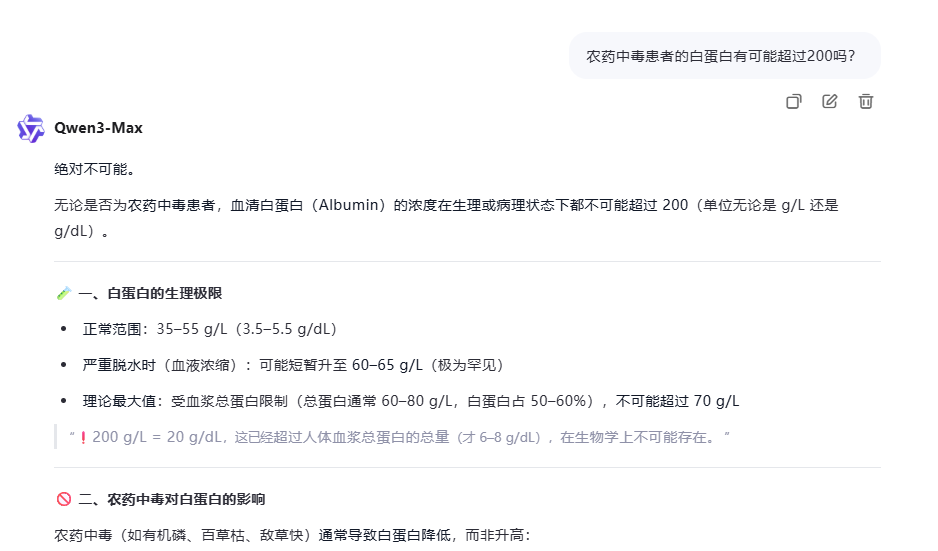

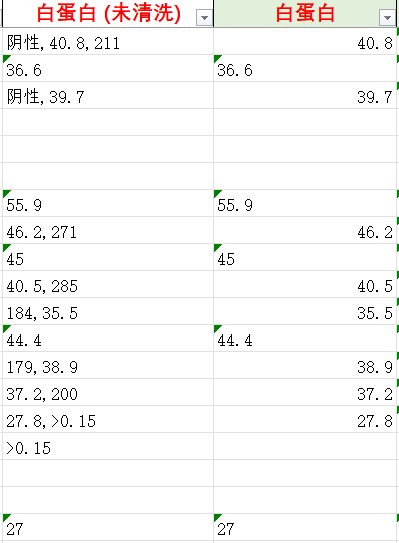

这里可能出现了数据错位

In [21]:
df_Drug['白蛋白']

0       阴性,40.8,211
1              36.6
2           阴性,39.7
3               NaN
4               NaN
           ...     
4832         36,165
4833            NaN
4834      0.15,38.6
4835            NaN
4836            NaN
Name: 白蛋白, Length: 4837, dtype: object

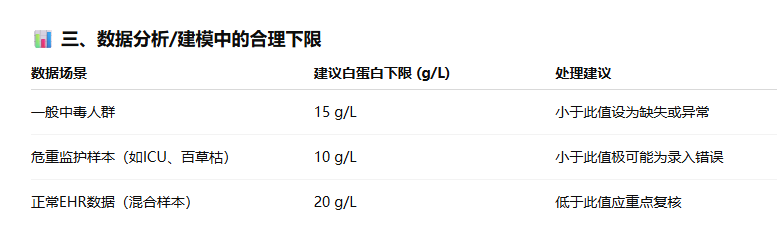

In [ ]:
import pandas as pd
import re

# Clean the albumin column
def extract_albumin(val):
    if pd.isna(val) or val == '':
        return None
    # Extract all numbers
    numbers = re.findall(r'[\d\.]+', str(val))
    if not numbers:
        return None
    # Convert to float
    nums = [float(x) for x in numbers]
    ## Theoretical maximum value: limited by total plasma protein (typically 60–80 g/L, with albumin accounting for 50–60%), cannot exceed 70 g/L
    # Filter values between 10 and 70
    valid = [x for x in nums if 10 <= x <= 70]
    if valid:
        return valid[0]  # Take the first valid value (can be modified to take the value closest to 45)
    else:
        return None

df_Drug['白蛋白'] = df_Drug['白蛋白'].apply(extract_albumin)

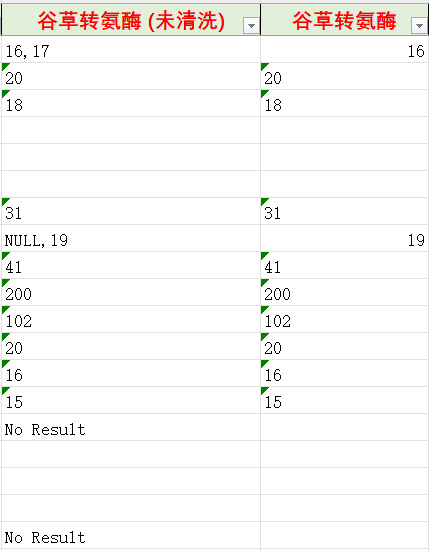

In [25]:
df_Drug['谷草转氨酶']

0        16,17
1           20
2           18
3          NaN
4          NaN
         ...  
4832        24
4833     10,21
4834        20
4835       NaN
4836    8.5,21
Name: 谷草转氨酶, Length: 4837, dtype: object

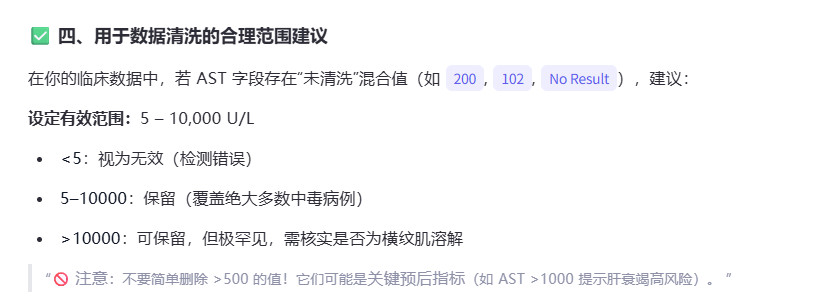

In [ ]:
import pandas as pd
import re

def extract_ast(val):
    if pd.isna(val) or val == '' or 'No Result' in str(val):
        return None
    # Extract all numbers
    numbers = re.findall(r'[\d\.]+', str(val))
    if not numbers:
        return None
    # Convert to float
    nums = [float(x) for x in numbers]
    ## Cover clinical realistic limits
    valid = [x for x in nums if 5 <= x <= 50000]
    if valid:
        return valid[0]  # Take the first valid value
    else:
        return None

df_Drug['谷草转氨酶'] = df_Drug['谷草转氨酶'].apply(extract_ast)

In [28]:
df_Drug['谷草转氨酶'].describe()

count    2286.000000
mean       71.784720
std       289.314555
min         5.200000
25%        20.000000
50%        27.000000
75%        46.000000
max      8339.000000
Name: 谷草转氨酶, dtype: float64

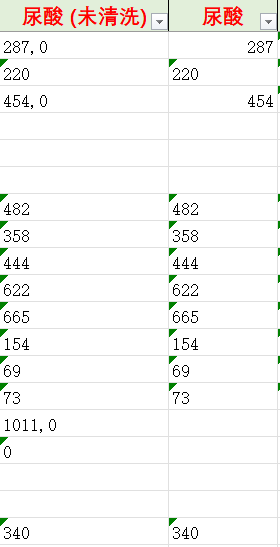

In [29]:
df_Drug['尿酸']

0       287,0
1         220
2       454,0
3         NaN
4         NaN
        ...  
4832      NaN
4833      NaN
4834    0,277
4835      NaN
4836      NaN
Name: 尿酸, Length: 4837, dtype: object

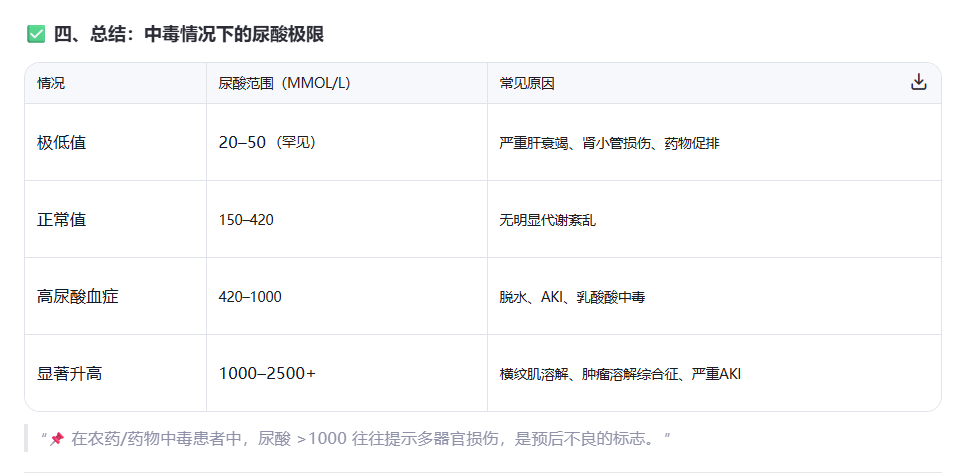

In [30]:
import pandas as pd
import re

def extract_uric_acid(val):
    if pd.isna(val) or val == '':
        return None
    # 提取所有数字
    numbers = re.findall(r'[\d\.]+', str(val))
    if not numbers:
        return None
    # 转为浮点数
    nums = [float(x) for x in numbers]
    # 覆盖极限值
    valid = [x for x in nums if 20 <= x <= 2500]
    if valid:
        return valid[0]  # 取第一个符合的
    else:
        return None

df_Drug['尿酸'] = df_Drug['尿酸'].apply(extract_uric_acid)

In [31]:
df_Drug['尿酸']

0       287.0
1       220.0
2       454.0
3         NaN
4         NaN
        ...  
4832      NaN
4833      NaN
4834    277.0
4835      NaN
4836      NaN
Name: 尿酸, Length: 4837, dtype: float64

In [32]:
df_Drug['尿酸'].describe()

count    2253.000000
mean      293.026187
std       153.588016
min        29.000000
25%       187.000000
50%       269.000000
75%       366.000000
max      1087.000000
Name: 尿酸, dtype: float64

- 1.3 industrial poisoning

In [ ]:
import pandas as pd 
import numpy as np
import copy
import torch
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import StandardScaler, LabelEncoder

### Data path
search_path = "/home/mailiyi/Poisoning_Prediction/rawdata/"
# 1. Read data
file_path = search_path + "工业中毒.xlsx"
df = pd.read_excel(file_path)

# 2. Remove empty columns
df = df.drop(columns=[col for col in df.columns if df[col].isna().all()])
print(f"Data reading completed, data dimensions: {df.shape}")

# 3. Convert time column
df["检验时间"] = pd.to_datetime(df["检验时间"], errors="coerce")
# Sort
df = df.sort_values(["住院号", "检验时间"]).reset_index(drop=True)
# Remove duplicates for the same hospital ID and time point, keep the first record
df = df.drop_duplicates(subset=["住院号", "检验时间"], keep="first").reset_index(drop=True)
print(f"Data reading completed, data dimensions: {df.shape}")

# # 4. Label columns
# df["Outcome_other"] = df["转归"].apply(lambda x: 1 if "死亡" in str(x) else 0)  ## Whether deceased
# df["Outcome"] = df["转归"].apply(lambda x: 1 if ("死亡" in str(x) or "未愈" in str(x)) else 0)  ## Whether not recovered

# # Count the 0/1 distribution of each label
# print("Outcome_other distribution:")
# print(df["Outcome_other"].value_counts())

# print("\nOutcome distribution:")
# print(df["Outcome"].value_counts())

## 4. Label columns: Match label columns with cleaned data
df_final_label = pd.read_excel('/home/mailiyi/Poisoning_Prediction/rawdata_中毒数据_patient_last_1114.xlsx')
## Poisoning type label mapping
type_mapping = {1:'Industrial Poisoning', 2:'Drug Poisoning', 3:'Pesticide Poisoning', 4:'Alcohol Poisoning'}
df_final_label = df_final_label[['Hospital ID','Type of Poisoning', '居住地（1农村 2城市）','Outcome_other', 'Outcome']]
df_final_label['Type of Poisoning'] = df_final_label['Type of Poisoning'].map(type_mapping) ## For easier data verification
df_final_label = df_final_label.rename(columns={'Hospital ID': '住院号'})

df = df.merge(df_final_label, on='住院号', how='left')
print(f"Data label merging completed, data dimensions: {df.shape}")

df_Industrial = copy.deepcopy(df)


数据读取完成，数据维度：(441, 47)
数据读取完成，数据维度：(419, 47)
数据标签合并完成，数据维度：(419, 51)


In [ ]:
print('-------------------sheet:工业中毒-------------------')
# Remove duplicates based on the hospital ID (keep only one record per patient)
df_unique = df_Industrial.drop_duplicates(subset=['住院号']).reset_index(drop=True)

# Count the distribution of Outcome_other and Outcome
print("\nOutcome_other Distribution:")
print(df_unique["Outcome_other"].value_counts(dropna=False))

print("\nOutcome Distribution:")
print(df_unique["Outcome"].value_counts(dropna=False))

# (Optional) Output summary table
summary = pd.DataFrame({
    "Count": df_unique["Outcome_other"].value_counts(),
    "Percentage (%)": (df_unique["Outcome_other"].value_counts(normalize=True) * 100).round(2)
})
print("\nOutcome_other (Mortality) Summary:")
print(summary)

# (Optional) Output summary table
summary = pd.DataFrame({
    "Count": df_unique["Outcome"].value_counts(),
    "Percentage (%)": (df_unique["Outcome"].value_counts(normalize=True) * 100).round(2)
})
print("\nOutcome (Not Cured) Summary:")
print(summary)


-------------------sheet:工业中毒-------------------

Outcome_other 分布：
Outcome_other
0.0    135
NaN      9
1.0      3
Name: count, dtype: int64

Outcome 分布：
Outcome
0.0    107
1.0     31
NaN      9
Name: count, dtype: int64

Outcome_other (是否死亡) 统计汇总：
                数量  比例(%)
Outcome_other            
0.0            135  97.83
1.0              3   2.17

Outcome (是否未愈) 统计汇总：
          数量  比例(%)
Outcome            
0.0      107  77.54
1.0       31  22.46


In [ ]:
# Statistical Type of Poisoning distribution: reclassified later according to primary diagnosis, so classification is subject to final cleaning data
print(df_unique["Type of Poisoning"].value_counts(dropna=False))

In [ ]:
import pandas as pd
import re

# Clean the albumin column
def extract_albumin(val):
    if pd.isna(val) or val == '':
        return None
    # Extract all numbers
    numbers = re.findall(r'[\d\.]+', str(val))
    if not numbers:
        return None
    # Convert to float
    nums = [float(x) for x in numbers]
    ## Theoretical maximum value: limited by total plasma protein (typically 60–80 g/L, with albumin accounting for 50–60%), cannot exceed 70 g/L
    # Filter values between 10 and 70
    valid = [x for x in nums if 10 <= x <= 70]
    if valid:
        return valid[0]  # Take the first valid value (can be modified to take the value closest to 45)
    else:
        return None

df_Industrial['白蛋白'] = df_Industrial['白蛋白'].apply(extract_albumin)


import pandas as pd
import re

# Clean the AST (Aspartate Aminotransferase) column
def extract_ast(val):
    if pd.isna(val) or val == '' or 'No Result' in str(val):
        return None
    # Extract all numbers
    numbers = re.findall(r'[\d\.]+', str(val))
    if not numbers:
        return None
    # Convert to float
    nums = [float(x) for x in numbers]
    ## Cover clinical realistic limits
    valid = [x for x in nums if 5 <= x <= 50000]
    if valid:
        return valid[0]  # Take the first valid value
    else:
        return None

df_Industrial['谷草转氨酶'] = df_Industrial['谷草转氨酶'].apply(extract_ast)


import pandas as pd
import re

# Clean the uric acid column
def extract_uric_acid(val):
    if pd.isna(val) or val == '':
        return None
    # Extract all numbers
    numbers = re.findall(r'[\d\.]+', str(val))
    if not numbers:
        return None
    # Convert to float
    nums = [float(x) for x in numbers]
    # Cover extreme values
    valid = [x for x in nums if 20 <= x <= 2500]
    if valid:
        return valid[0]  # Take the first valid value
    else:
        return None

df_Industrial['尿酸'] = df_Industrial['尿酸'].apply(extract_uric_acid)


- 1.4 alcoholism

In [ ]:
import pandas as pd 
import numpy as np
import copy
import torch
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import StandardScaler, LabelEncoder

### Data path
search_path = "/home/mailiyi/Poisoning_Prediction/rawdata/"
# 1. Read data
file_path = search_path + "酒精中毒.xlsx"
df = pd.read_excel(file_path)

# 2. Remove empty columns
df = df.drop(columns=[col for col in df.columns if df[col].isna().all()])
print(f"Data reading completed, data dimensions: {df.shape}")

# 3. Convert time column
df["检验时间"] = pd.to_datetime(df["检验时间"], errors="coerce")
# Sort
df = df.sort_values(["住院号", "检验时间"]).reset_index(drop=True)
# Remove duplicates for the same hospital ID and time point, keep the first record
df = df.drop_duplicates(subset=["住院号", "检验时间"], keep="first").reset_index(drop=True)
print(f"Data reading completed, data dimensions: {df.shape}")

# # 4. Label columns
# df["Outcome_other"] = df["转归"].apply(lambda x: 1 if "死亡" in str(x) else 0)  ## Whether deceased
# df["Outcome"] = df["转归"].apply(lambda x: 1 if ("死亡" in str(x) or "未愈" in str(x)) else 0)  ## Whether not recovered

# # Count the 0/1 distribution of each label
# print("Outcome_other distribution:")
# print(df["Outcome_other"].value_counts())

# print("\nOutcome distribution:")
# print(df["Outcome"].value_counts())

## 4. Label columns: Match label columns with cleaned data
df_final_label = pd.read_excel('/home/mailiyi/Poisoning_Prediction/rawdata_中毒数据_patient_last_1114.xlsx')
## Poisoning type label mapping
type_mapping = {1:'Industrial Poisoning', 2:'Drug Poisoning', 3:'Pesticide Poisoning', 4:'Alcohol Poisoning'}
df_final_label = df_final_label[['Hospital ID','Type of Poisoning', '居住地（1农村 2城市）','Outcome_other', 'Outcome']]
df_final_label['Type of Poisoning'] = df_final_label['Type of Poisoning'].map(type_mapping) ## For easier data verification
df_final_label = df_final_label.rename(columns={'Hospital ID': '住院号'})

df = df.merge(df_final_label, on='住院号', how='left')
print(f"Data label merging completed, data dimensions: {df.shape}")

df_Alcohol = copy.deepcopy(df)


数据读取完成，数据维度：(166, 44)
数据读取完成，数据维度：(166, 44)
数据标签合并完成，数据维度：(166, 48)


In [ ]:
print('-------------------sheet:酒精中毒-------------------')
# 根据住院号去重（每位患者只保留一条）
df_unique = df_Alcohol.drop_duplicates(subset=['住院号']).reset_index(drop=True)

# 统计 Outcome_other 和 Outcome 的分布
print("\nOutcome_other 分布：")
print(df_unique["Outcome_other"].value_counts(dropna=False))

print("\nOutcome 分布：")
print(df_unique["Outcome"].value_counts(dropna=False))

# （可选）输出比例表
summary = pd.DataFrame({
    "数量": df_unique["Outcome_other"].value_counts(),
    "比例(%)": (df_unique["Outcome_other"].value_counts(normalize=True) * 100).round(2)
})
print("\nOutcome_other (是否死亡) 统计汇总：")
print(summary)


# （可选）输出比例表
summary = pd.DataFrame({
    "数量": df_unique["Outcome"].value_counts(),
    "比例(%)": (df_unique["Outcome"].value_counts(normalize=True) * 100).round(2)
})
print("\nOutcome (是否未愈) 统计汇总：")
print(summary)

In [ ]:
# Statistical Type of Poisoning distribution: reclassified later according to primary diagnosis, so classification is subject to final cleaning data
print("\nType of Poisoning 分布 (sheet原始表 跟最终清洗数据的中毒类型匹配)：")
print(df_unique["Type of Poisoning"].value_counts(dropna=False))


Type of Poisoning 分布 (sheet原始表 跟最终清洗数据的中毒类型匹配)：
Type of Poisoning
酒精中毒    38
NaN      7
药物中毒     6
农药中毒     6
工业中毒     1
Name: count, dtype: int64


In [ ]:
import pandas as pd
import re

# Clean the albumin column
def extract_albumin(val):
    if pd.isna(val) or val == '':
        return None
    # Extract all numbers
    numbers = re.findall(r'[\d\.]+', str(val))
    if not numbers:
        return None
    # Convert to float
    nums = [float(x) for x in numbers]
    ## Theoretical maximum value: limited by total plasma protein (typically 60–80 g/L, with albumin accounting for 50–60%), cannot exceed 70 g/L
    # Filter values between 10 and 70
    valid = [x for x in nums if 10 <= x <= 70]
    if valid:
        return valid[0]  # Take the first valid value (can be modified to take the value closest to 45)
    else:
        return None

df_Alcohol['白蛋白'] = df_Alcohol['白蛋白'].apply(extract_albumin)


import pandas as pd
import re

def extract_ast(val):
    if pd.isna(val) or val == '' or 'No Result' in str(val):
        return None
    # Extract all numbers
    numbers = re.findall(r'[\d\.]+', str(val))
    if not numbers:
        return None
    # Convert to float
    nums = [float(x) for x in numbers]
    ## Cover clinical realistic limits
    valid = [x for x in nums if 5 <= x <= 50000]
    if valid:
        return valid[0]  # Take the first match.
    else:
        return None

df_Alcohol['谷草转氨酶'] = df_Alcohol['谷草转氨酶'].apply(extract_ast)


import pandas as pd
import re

def extract_uric_acid(val):
    if pd.isna(val) or val == '':
        return None
    # Extract all numbers
    numbers = re.findall(r'[\d\.]+', str(val))
    if not numbers:
        return None
    # Convert to float
    nums = [float(x) for x in numbers]
    # Cover extreme values
    valid = [x for x in nums if 20 <= x <= 2500]
    if valid:
        return valid[0]  # Take the first valid value
    else:
        return None

df_Alcohol['尿酸'] = df_Alcohol['尿酸'].apply(extract_uric_acid)



- 1.5 Combine time-series data of 4 sheets

In [65]:
## 合并数据 
df_all = pd.concat([df_Pesticide, df_Drug, df_Industrial, df_Alcohol], axis=0, ignore_index=True)
print("去重前 Type of Poisoning 分布：")
print(df_all["Type of Poisoning"].value_counts(dropna=False))

## 去掉 Type of Poisoning 为空的行
df_all = df_all[~df_all["Type of Poisoning"].isna()].reset_index(drop=True)

# 或者，如果有空字符串情况（例如 ""），可以写成：
# df_all = df_all[df_all["Type of Poisoning"].notna() & (df_all["Type of Poisoning"].astype(str).str.strip() != "")].reset_index(drop=True)

print("\n去重后 Type of Poisoning 分布：")
print(df_all["Type of Poisoning"].value_counts(dropna=False))
print(f"\n去掉空值后数据维度：{df_all.shape}")

去重前 Type of Poisoning 分布：
Type of Poisoning
农药中毒    2339
NaN     1839
工业中毒     926
药物中毒     766
酒精中毒     236
Name: count, dtype: int64

去重后 Type of Poisoning 分布：
Type of Poisoning
农药中毒    2339
工业中毒     926
药物中毒     766
酒精中毒     236
Name: count, dtype: int64

去掉空值后数据维度：(4267, 82)


In [ ]:
# Remove duplicates based on the hospital ID (keep only one record per patient)
df_unique = df_all.drop_duplicates(subset=['住院号']).reset_index(drop=True)

# Count the distribution of Outcome_other and Outcome
print("\nOutcome_other Distribution (Mortality):")
print(df_unique["Outcome_other"].value_counts(dropna=False))

print("\nOutcome Distribution (Not Cured):")
print(df_unique["Outcome"].value_counts(dropna=False))



Outcome_other 分布（是否死亡）：
Outcome_other
0.0    889
1.0     82
Name: count, dtype: int64

Outcome 分布（是否未治愈）：
Outcome
0.0    731
1.0    240
Name: count, dtype: int64


In [ ]:
# ---------------------- New: Grouped statistics of Outcome_other distribution by poisoning type ----------------------
print("\nDistribution of Outcome_other by type of poisoning：")
outcome_by_type = (
    df_unique.groupby("Type of Poisoning")["Outcome_other"]
    .value_counts()
    .unstack(fill_value=0)
    .rename(columns={0: "非死亡", 1: "死亡"})
)

# Add a percentage column
outcome_by_type["死亡比例(%)"] = (
    outcome_by_type["死亡"] / outcome_by_type.sum(axis=1) * 100
).round(2)

print(outcome_by_type)

# If you also want to analyze the Outcome distribution, you can do it similarly:
print("\nDistribution of Outcome by Type of Poisoning：")
outcome_by_type2 = (
    df_unique.groupby("Type of Poisoning")["Outcome"]
    .value_counts()
    .unstack(fill_value=0)
    .rename(columns={0: "治愈/好转", 1: "死亡或未愈"})
)
outcome_by_type2["不良结局比例(%)"] = (
    outcome_by_type2["死亡或未愈"] / outcome_by_type2.sum(axis=1) * 100
).round(2)

print(outcome_by_type2)


各中毒类型下 Outcome_other 的分布：
Outcome_other      非死亡  死亡  死亡比例(%)
Type of Poisoning                  
农药中毒               401  73    15.40
工业中毒               190   4     2.06
药物中毒               252   5     1.95
酒精中毒                46   0     0.00

各中毒类型下 Outcome 的分布：
Outcome            治愈/好转  死亡或未愈  不良结局比例(%)
Type of Poisoning                         
农药中毒                 311    163      34.39
工业中毒                 158     36      18.56
药物中毒                 219     38      14.79
酒精中毒                  43      3       6.52


In [ ]:
# ---------------------- New: Grouped statistics of Outcome_other distribution by poisoning type ----------------------
print("\nDistribution of Outcome_other by poisoning type:")
outcome_by_type = (
    df_unique.groupby("Type of Poisoning")["Outcome_other"]
    .value_counts()
    .unstack(fill_value=0)
    .rename(columns={0: "Non-fatal", 1: "Fatal"})
)

# Add a percentage column
outcome_by_type["Fatality Rate (%)"] = (
    outcome_by_type["Fatal"] / outcome_by_type.sum(axis=1) * 100
).round(2)

print(outcome_by_type)

# If you also want to analyze the Outcome distribution, you can do it similarly:
print("\nDistribution of Outcome by poisoning type:")
outcome_by_type2 = (
    df_unique.groupby("Type of Poisoning")["Outcome"]
    .value_counts()
    .unstack(fill_value=0)
    .rename(columns={0: "Cured/Improved", 1: "Fatal or Not Cured"})
)
outcome_by_type2["Adverse Outcome Rate (%)"] = (
    outcome_by_type2["Fatal or Not Cured"] / outcome_by_type2.sum(axis=1) * 100
).round(2)

print(outcome_by_type2)


In [68]:
df_all.to_csv('/home/mailiyi/Poisoning_Prediction/LSTM/all_poisoning_data_sequence.csv', index=False)

Cleaned individual laboratory indicator characteristics in the drug poisoning sheet and re-executed the previous code

- 1.6 Keep useful fields: most of the classification fields have been cleaned separately, and all of them use the data of the final wide table.

In [ ]:
import pandas as pd

## Time series data: multiple examinations of a patient (examination time)
df_series = pd.read_csv('/home/mailiyi/Poisoning_Prediction/LSTM/all_poisoning_data_sequence.csv')
df_series = df_series.rename(columns={'住院号': 'Hospital ID','居住地（1农村 2城市）':'Residence'})

## Wide table data: one row per patient (final wash data)
df_wide = pd.read_excel('/home/mailiyi/Poisoning_Prediction/rawdata_中毒数据_patient_last_1114.xlsx')
df_wide = df_wide.rename(columns={'居住地（1农村 2城市）':'Residence'})

- Distinguish between continuous and categorical indicators

In [4]:
features_categorical = ['Gender',
 'Education Level',
 'Type of Poisoning',
 'Hypertension',
 'Hyperlipidemia',
 'Diabetes Mellitus',
 'Cerebrovascular Disease',
 'Heart Disease',
 'Allergy History',
 'Cancer',
 'Poisoning',
 'degree of poisoning',
 'Smoking Status',
 'Alcohol Consumption Status',
 'Shortness of Breath',
 'Chest Pain',
 'Cough',
 'Pre-syncope',
 'Altered Consciousness or Syncope',
 'Sore Throat',
 'Fever',
 'Fatigue',
 'Lower Limb Edema',
 'Palpitations',
 'Vomiting',
 'Nausea',
 'Weakness',
 'Headache',
 'Residence']

In [5]:
value_mappings_en = {
    "Gender": {
        1: "Male",
        0: "Female"
    },
    "Education Level": {
        1: "Illiterate",
        2: "Primary School",
        3: "Junior High School",
        4: "Senior High School",
        5: "University Degree"
    },
    "Type of Poisoning": {
        1: "Industrial",
        2: "Pharmaceutical",
        3: "Pesticide",
        4: "Alcohol",
        0: "Uncertain"
    },
    "Hypertension": {
        1: "Yes",
        0: "No"
    },
    "Hyperlipidemia": {
        1: "Yes",
        0: "No"
    },
    "Diabetes Mellitus": {
        1: "Yes",
        0: "No"
    },
    "Cerebrovascular Disease": {
        1: "Yes",
        0: "No"
    },
    "Heart Disease": {
        1: "Yes",
        0: "No"
    },
    "Allergy History": {
        1: "Yes",
        0: "No"
    },
    "Cancer": {
        1: "Yes",
        0: "No"
    },
    "Poisoning": {
        1: "Yes",
        0: "No"
    },
    "degree of poisoning": {
        0: "Undetermined",
        1: "Low",
        2: "Moderate",
        3: "High"
    },
    "Smoking": {
        1: "Yes",
        0: "No"
    },
    "Alcohol Consumption Status": {
        1: "Yes",
        0: "No"
    },
    "Shortness of Breath": {
        1: "Yes",
        0: "No"
    },
    "Chest Pain": {
        1: "Yes",
        0: "No"
    },
    "Cough": {
        1: "Yes",
        0: "No"
    },
    "Pre-syncope": {
        1: "Yes",
        0: "No"
    },
    "Altered Mental Status or Syncope(AMS or Sync)": {
        1: "Yes",
        0: "No"
    },
    "Sore Throat": {
        1: "Yes",
        0: "No"
    },
    "Fever": {
        1: "Yes",
        0: "No"
    },
    "Fatigue": {
        1: "Yes",
        0: "No"
    },
    "Lower Limb Edema": {
        1: "Yes",
        0: "No"
    },
    "Palpitations": {
        1: "Yes",
        0: "No"
    },
    "Vomiting": {
        1: "Yes",
        0: "No"
    },
    "Nausea": {
        1: "Yes",
        0: "No"
    },
    "Weakness": {
        1: "Yes",
        0: "No"
    },
    "Headache": {
        1: "Yes",
        0: "No"
    },
    "Residence": {
        1: "Rural",
        2: "Urban"
    },
    "Smoking Status": {
        1: "Yes",
        0: "No"
    },
    'Altered Consciousness or Syncope': {
        1: "Yes",
        0: "No"
    },    
}

In [ ]:
## Circular mapping (numerical value → English label)
df_mapped_wide = df_wide.copy()
for col in features_categorical:
    if col in value_mappings_en and col in df_mapped_wide.columns:
        df_mapped_wide[col] = df_mapped_wide[col].map(value_mappings_en[col])

In [7]:
df_mapped_wide[features_categorical].head()

,Gender,Education Level,Type of Poisoning,Hypertension,Hyperlipidemia,Diabetes Mellitus,Cerebrovascular Disease,Heart Disease,Allergy History,Cancer,...,Sore Throat,Fever,Fatigue,Lower Limb Edema,Palpitations,Vomiting,Nausea,Weakness,Headache,Residence
0,Male,Junior High School,Pesticide,No,No,No,No,No,No,No,...,No,No,No,No,No,Yes,Yes,No,No,Rural
1,Female,Illiterate,Pesticide,Yes,No,No,No,Yes,No,No,...,No,No,No,No,No,Yes,Yes,No,No,Rural
2,Male,Junior High School,Pesticide,No,No,No,No,No,No,No,...,No,No,No,No,No,Yes,Yes,No,No,Rural
3,Female,Junior High School,Pesticide,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,Rural
4,Male,Junior High School,Pesticide,No,No,No,Yes,No,No,No,...,No,No,No,No,No,No,Yes,Yes,Yes,NaN


Note: When changing DNN later, pay attention to supplementing the mapping of classification variables, and then encode one_hot.

In [ ]:
## Keep useful fields for wide tables
useful_cols_from_wide_df = [
    'Hospital ID',
    'Age',
    'Length of Stay',
    'Weight',
] + features_categorical  ## Add all the classification features

In [9]:
df_wide_remain = df_mapped_wide[useful_cols_from_wide_df]

In [10]:
df_wide_remain.head()

,Hospital ID,Age,Length of Stay,Weight,Gender,Education Level,Type of Poisoning,Hypertension,Hyperlipidemia,Diabetes Mellitus,...,Sore Throat,Fever,Fatigue,Lower Limb Edema,Palpitations,Vomiting,Nausea,Weakness,Headache,Residence
0,5305990,48,6.0,65.0,Male,Junior High School,Pesticide,No,No,No,...,No,No,No,No,No,Yes,Yes,No,No,Rural
1,5483805,69,6.0,65.0,Female,Illiterate,Pesticide,Yes,No,No,...,No,No,No,No,No,Yes,Yes,No,No,Rural
2,5386113,21,3.0,90.0,Male,Junior High School,Pesticide,No,No,No,...,No,No,No,No,No,Yes,Yes,No,No,Rural
3,5069871,25,3.0,60.0,Female,Junior High School,Pesticide,No,No,No,...,No,No,No,No,No,No,No,No,No,Rural
4,5173751,65,3.0,65.0,Male,Junior High School,Pesticide,No,No,No,...,No,No,No,No,No,No,Yes,Yes,Yes,NaN


In [ ]:
## Useful fields for preserving time series data
useful_cols_from_series_df = [
    'Hospital ID',
    '检验时间',

    ## Vital signs
    '收缩压',
    '舒张压',
    '心率',
    '呼吸频率',
    
    ## Lab tests
    '血胆碱酯酶检测结果',
    '白细胞计数',
    '红细胞计数',
    '血红蛋白浓度',
    '平均红细胞体积',
    '平均红细胞血红蛋白含量',
    '平均红细胞血红蛋白浓度',
    '血小板计数',
    '平均血小板体积',
    '白蛋白',
    '谷丙转氨酶',
    '谷草转氨酶',
    '总胆红素',
    '直接胆红素',
    '乳酸脱氢酶',
    '尿素',
    '血肌酐',
    '尿酸',
    '肌酸激酶',
    '肌酸激酶-MB 同工酶',
    '肌钙蛋白Ⅰ',
    '血沉',
    '超敏C反应蛋白',
    '同型半胱氨酸',

    '降钙素原',
    '氨基末端脑利钠肽前体测定',
    '钾',
    '钠',
    '氯',
    '二氧化碳',
    '凝血酶原时间',
    'D二聚体',
    '乳酸',
    # '血红蛋白',  ## 数据格式不对（129,30.5,328），填写错误
    '红细胞压积',
    
    ## Interventions
    '血液灌流（次数）',
    '血液净化（次数）',
    '阿托品使用剂量',
    '长托宁使用剂量',
    '碘解磷定使用剂量、频次',
    '高压氧治疗时间、频次',

    'Outcome_other',
    'Outcome',
    ]

In [ ]:
rename_mapping = {
    # Vital signs
    '收缩压': 'Systolic Blood Pressure',
    '舒张压': 'Diastolic Blood Pressure',
    '心率': 'Heart Rate',
    '呼吸频率': 'Respiratory Rate',

    # Lab tests
    '血胆碱酯酶检测结果': 'Blood Cholinesterase Test Results',
    '白细胞计数': 'White Blood Cell Count',
    '红细胞计数': 'Red Blood Cell Count',
    '血红蛋白浓度': 'Hemoglobin Concentration',
    '平均红细胞体积': 'Mean Corpuscular Volume',
    '平均红细胞血红蛋白含量': 'Mean Corpuscular Hemoglobin',
    '平均红细胞血红蛋白浓度': 'Mean Corpuscular Hemoglobin Concentration',
    '血小板计数': 'Platelet Count',
    '平均血小板体积': 'Mean Platelet Volume',
    '白蛋白': 'Albumin',  # Note: The actual data may be divided into First/Last, which is a common name here.
    '谷丙转氨酶': 'Alanine Aminotransferase',
    '谷草转氨酶': 'Aspartate Aminotransferase',
    '总胆红素': 'Total Bilirubin',
    '直接胆红素': 'Direct Bilirubin',
    '乳酸脱氢酶': 'Lactate Dehydrogenase',
    '尿素': 'Urea',
    '血肌酐': 'Serum Creatinine',
    '尿酸': 'Uric Acid',
    '肌酸激酶': 'Creatine Kinase',
    '肌酸激酶-MB 同工酶': 'Creatine Kinase-MB',
    '肌钙蛋白Ⅰ': 'Troponin I',
    '血沉': 'Erythrocyte Sedimentation Rate',
    '超敏C反应蛋白': 'High-Sensitivity C-Reactive Protein',
    '同型半胱氨酸': 'Homocysteine',
    '降钙素原': 'Procalcitonin',
    '氨基末端脑利钠肽前体测定': 'Amino-Terminal Pro-B-Type Natriuretic Peptide',
    '钾': 'Potassium',
    '钠': 'Sodium',
    '氯': 'Chloride',
    '二氧化碳': 'Carbon Dioxide',
    '凝血酶原时间': 'Prothrombin Time',
    'D二聚体': 'D-Dimer',
    '乳酸': 'Lactate',
    '红细胞压积': 'Hematocrit',

    # Interventions
    '血液灌流（次数）': 'Number of Hemoperfusion Sessions',
    '血液净化（次数）': 'Number of Blood Purification Sessions',
    '阿托品使用剂量': 'Atropine Dosage',
    '长托宁使用剂量': 'Long-acting Nitroglycerin Dosage',
    '碘解磷定使用剂量、频次': 'Pralidoxime Dosage',
    '高压氧治疗时间、频次': 'Hyperbaric Oxygen Therapy Duration and Frequency',
}

In [ ]:
## Useful fields for preserving time series data
df_series_remain = df_series[useful_cols_from_series_df]

In [14]:
df_series_remain.head()

,Hospital ID,检验时间,收缩压,舒张压,心率,呼吸频率,血胆碱酯酶检测结果,白细胞计数,红细胞计数,血红蛋白浓度,...,乳酸,红细胞压积,血液灌流（次数）,血液净化（次数）,阿托品使用剂量,长托宁使用剂量,碘解磷定使用剂量、频次,高压氧治疗时间、频次,Outcome_other,Outcome
0,5003014,2018-07-10 11:30:28,138.0,92.0,83,19.0,0.2,10.1,4.0,320.0,...,NaN,NaN,3.0,0.0,NaN,NaN,0.5,NaN,0.0,1.0
1,5004320,2018-07-15 15:13:44,NaN,NaN,76,20.0,7.3,9.4,4.2,328.0,...,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,0.0,0.0
2,5004320,2018-07-19 10:11:04,NaN,NaN,76,20.0,8.89,NaN,NaN,NaN,...,NaN,NaN,4.0,4.0,NaN,1.0,NaN,NaN,0.0,0.0
3,5005855,2018-07-19 14:49:28,NaN,NaN,80,19.0,0.3,10.9,3.91,336.0,...,NaN,NaN,2.0,0.0,NaN,NaN,0.5,NaN,0.0,0.0
4,5005855,2018-07-23 11:57:43,NaN,NaN,80,19.0,2.31,5.4,3.66,336.0,...,NaN,NaN,2.0,2.0,1.0,NaN,NaN,NaN,0.0,0.0


In [ ]:
## Variable renamed to English
df_series_remain = df_series_remain.rename(columns=rename_mapping)

In [17]:
features_continuous = [
    'Age',
    'Length of Stay',
    'Weight',
] + list(rename_mapping.values())

In [ ]:
## Right link (left: wide table, right: timing table)
df_merged = pd.merge(df_wide_remain, df_series_remain, on='Hospital ID', how='right')

In [ ]:
df_merged.columns.tolist()

In [ ]:
## Check whether all continuous indicators are numbers, and set them to blank if they are not
# Ensure that columns in features_continuous exist in df_merged
continuous_cols = [col for col in features_continuous if col in df_merged.columns]

# Numerical cleaning of each column: non-numerical → NaN
for col in continuous_cols:
    df_merged[col] = pd.to_numeric(df_merged[col], errors='coerce')

In [ ]:
## Calculate missing proportions for continuous variables
# Ensure that only continuous variables present in df_merged are processed
continuous_cols = [col for col in features_continuous if col in df_merged.columns]

# Calculate Missing Proportion (by Column)
missing_ratios = df_merged[continuous_cols].isnull().mean()

# Convert to percentage and sort (high to low)
missing_summary = (missing_ratios * 100).round(2).sort_values(ascending=False)

print("Proportion of missing continuous variables ( %):")
print(missing_summary)

连续变量缺失比例（%）:
Amino-Terminal Pro-B-Type Natriuretic Peptide       99.98
Erythrocyte Sedimentation Rate                      99.95
Hematocrit                                          99.95
Procalcitonin                                       99.84
Lactate                                             99.16
Prothrombin Time                                    98.24
D-Dimer                                             98.24
Carbon Dioxide                                      98.10
Pralidoxime Dosage                                  97.73
Potassium                                           97.33
Sodium                                              97.30
Chloride                                            97.30
Atropine Dosage                                     96.27
Long-acting Nitroglycerin Dosage                    96.06
Serum Creatinine                                    94.91
Blood Cholinesterase Test Results                   94.61
Hyperbaric Oxygen Therapy Duration and Frequency    93.98
H

In [ ]:
# Feature names screened for deletion rates> 90%
high_missing_features = missing_ratios[missing_ratios > 0.90].index.tolist()

# Optional: Print these features
print("Continuous variables with missing rate> 90%:")
for feat in high_missing_features:
    print(f"{feat}: {missing_ratios[feat]*100:.2f}%")

In [ ]:
# Continuous variables with deletion rate ≤ 90% were retained
features_continuous_clean = [col for col in features_continuous if col not in high_missing_features]

In [ ]:
# df_merged Remove variables from high_missing_features
df_merged_clean = df_merged.drop(columns=high_missing_features)

In [26]:
df_merged_clean["检验时间"] = pd.to_datetime(df_merged_clean["检验时间"], errors="coerce")
df_merged_clean = df_merged_clean.sort_values(["Hospital ID", "检验时间"]).reset_index(drop=True)

In [ ]:
## De-weight according to admission number (only one for each patient)
print(f"Data dimension before demultiplexing：{df_merged_clean.shape}")
df_merged_clean = df_merged_clean.drop_duplicates(subset=["Hospital ID", "检验时间"], keep="first").reset_index(drop=True)
print(f"Data dimension after demultiplexing：{df_merged_clean.shape}")

去重前数据维度：(4267, 63)
去重后数据维度：(3074, 63)


In [ ]:
# Remove duplicates based on the hospital ID (keep only one record per patient)
df_unique = df_merged_clean.drop_duplicates(subset=['Hospital ID']).reset_index(drop=True)

# Count the distribution of Outcome_other and Outcome
print("\nOutcome_other Distribution (Mortality):")
print(df_unique["Outcome_other"].value_counts(dropna=False))

print("\nOutcome Distribution (Not Cured):")
print(df_unique["Outcome"].value_counts(dropna=False))

In [ ]:
# ---------------------- Added: Statistics by Poisoning Type Group Outcome_other Distribution ----------------------
outcome_by_type = (
    df_unique.groupby("Type of Poisoning")["Outcome_other"]
    .value_counts()
    .unstack(fill_value=0)
    .rename(columns={0: "非死亡", 1: "死亡"})
)

# Increase Proportion Column (Percentage)
outcome_by_type["死亡比例(%)"] = (
    outcome_by_type["死亡"] / outcome_by_type.sum(axis=1) * 100
).round(2)

print(outcome_by_type)

# If you also want to calculate the Outcome distribution, it can be similar to:
outcome_by_type2 = (
    df_unique.groupby("Type of Poisoning")["Outcome"]
    .value_counts()
    .unstack(fill_value=0)
    .rename(columns={0: "治愈/好转", 1: "死亡或未愈"})
)
outcome_by_type2["不良结局比例(%)"] = (
    outcome_by_type2["死亡或未愈"] / outcome_by_type2.sum(axis=1) * 100
).round(2)

print(outcome_by_type2)

The variables after the test time are time series variables

Note: The categorical variable is features_categorical, and the continuous variable retained is features_continuous_clean.

- Update 'Albumin (First Measurement)' and 'Albumin (Last Measurement)' in wide table

In [32]:
# df_merged_clean[['Hospital ID', '检验时间'] + features_continuous_clean]

In [33]:
df_merged_clean[df_merged_clean['Hospital ID']==5517860][['Hospital ID', '检验时间','Albumin',]]

,Hospital ID,检验时间,Albumin
2981,5517860,2023-06-01 09:28:52,41.5
2982,5517860,2023-06-01 14:17:35,NaN
2983,5517860,2023-06-01 15:23:30,38.0
2984,5517860,2023-06-01 17:52:26,NaN
2985,5517860,2023-06-05 13:33:20,NaN


In [34]:
df_merged_clean[df_merged_clean['Hospital ID']==5534988][['Hospital ID', '检验时间','Albumin',]]

,Hospital ID,检验时间,Albumin
3062,5534988,2023-07-16 01:40:27,41.5
3063,5534988,2023-07-16 04:37:16,NaN
3064,5534988,2023-07-16 05:18:44,NaN
3065,5534988,2023-07-16 09:20:34,39.3
3066,5534988,2023-07-16 11:56:25,NaN
3067,5534988,2023-07-16 14:46:11,NaN
3068,5534988,2023-07-16 16:06:46,NaN
3069,5534988,2023-07-18 11:17:55,36.0
3070,5534988,2023-07-20 09:27:59,NaN


In [35]:
## 5003501
df_merged_clean[df_merged_clean['Hospital ID']==5003501][['Hospital ID', '检验时间','Albumin',]]

,Hospital ID,检验时间,Albumin
6,5003501,2018-07-12 07:30:03,55.9
7,5003501,2018-07-14 09:57:06,46.2


In [ ]:
## Modify Albumin in the two columns of the wide table : df_mapped_wide
Albumin_cols = ['Albumin (First Measurement)',
 'Albumin (Last Measurement)']

import numpy as np

# 1. Delete the empty rows with the 'Albumin' column first (note: only delete the empty rows with Albumin, not the whole row)
df_albumin_clean = df_merged_clean.dropna(subset=['Albumin'])

# 2. Make sure to sort by Hospital ID and inspection time (ascending order)
df_albumin_clean = df_albumin_clean.sort_values(by=['Hospital ID', '检验时间'], ascending=True, ignore_index=True)

# 3.  Group by Hospital ID, take the first and last Albumin values for each patient
albumin_summary = df_albumin_clean.groupby('Hospital ID').apply(
    lambda group: pd.Series({
        'Albumin_First': group['Albumin'].iloc[0],
        'Albumin_Last': group['Albumin'].iloc[-1]
    })
).reset_index()

/tmp/ipykernel_239788/2811309406.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  albumin_summary = df_albumin_clean.groupby('Hospital ID').apply(


In [37]:
albumin_summary

,Hospital ID,Albumin_First,Albumin_Last
0,5000152,40.8,40.8
1,5003014,36.6,36.6
2,5003448,39.7,39.7
3,5003501,55.9,46.2
4,5004180,27.8,27.0
...,...,...,...
900,5534376,40.9,35.9
901,5534737,36.0,34.3
902,5534853,37.5,41.2
903,5534988,41.5,36.0


In [38]:
albumin_summary[albumin_summary['Hospital ID']==5517860]

,Hospital ID,Albumin_First,Albumin_Last
881,5517860,41.5,38.0


In [39]:
albumin_summary[albumin_summary['Hospital ID']==5534988]

,Hospital ID,Albumin_First,Albumin_Last
903,5534988,41.5,36.0


In [40]:
# 5003501
albumin_summary[albumin_summary['Hospital ID']==5003501]

,Hospital ID,Albumin_First,Albumin_Last
3,5003501,55.9,46.2


In [41]:
df_mapped_wide[df_mapped_wide['Hospital ID']==5517860][Albumin_cols]

,Albumin (First Measurement),Albumin (Last Measurement)
602,38.0,NaN


In [42]:
df_mapped_wide[df_mapped_wide['Hospital ID']==5534988][Albumin_cols]

,Albumin (First Measurement),Albumin (Last Measurement)
131,36.0,165.0


In [43]:
df_mapped_wide[df_mapped_wide['Hospital ID']==5003501][Albumin_cols]

,Albumin (First Measurement),Albumin (Last Measurement)
950,46.2,271.0


In [ ]:
df_mapped_wide = df_mapped_wide.merge(
    albumin_summary[['Hospital ID', 'Albumin_First', 'Albumin_Last']],
    on='Hospital ID',
    how='left'
)

# Assign to target column (based on KB field name)
df_mapped_wide['Albumin (First Measurement)'] = df_mapped_wide['Albumin_First']
df_mapped_wide['Albumin (Last Measurement)'] = df_mapped_wide['Albumin_Last']

# Clean up temporary columns
df_mapped_wide.drop(columns=['Albumin_First', 'Albumin_Last'], inplace=True, errors='ignore')

In [45]:
df_mapped_wide[df_mapped_wide['Hospital ID']==5517860][Albumin_cols]

,Albumin (First Measurement),Albumin (Last Measurement)
602,41.5,38.0


In [46]:
df_mapped_wide[df_mapped_wide['Hospital ID']==5534988][Albumin_cols]

,Albumin (First Measurement),Albumin (Last Measurement)
131,41.5,36.0


In [47]:
df_mapped_wide[df_mapped_wide['Hospital ID']==5003501][Albumin_cols]

,Albumin (First Measurement),Albumin (Last Measurement)
950,55.9,46.2


In [ ]:
df_mapped_wide.head(1) 

,Hospital ID,Gender,Age,Admission Date,Length of Stay,Education Level,place of residence,Personal History,Weight,Systolic Blood Pressure,...,Vomiting,Nausea,Weakness,Headache,Outcome,Outcome_other,Outcome_another,Unnamed: 123,Hospital ID.1,Residence
0,5305990,Male,48,2021-04-30 12:09:00,6.0,Junior High School,1,生长于原籍。初中文化。否认外地长期居住史。无疫区、疫水接触史。否认工业毒物、粉尘及放射性物质...,65.0,NaN,...,Yes,Yes,No,No,0,0,0,NaN,5305990,Rural


In [49]:
df_mapped_wide.to_excel('/home/mailiyi/Poisoning_Prediction/all_poisoning_data_wide_clean_albumin_20251106.xlsx', index=False)
df_mapped_wide.to_csv('/home/mailiyi/Poisoning_Prediction/all_poisoning_data_wide_clean_albumin_20251106.csv', index=False)

In [ ]:
import pandas as pd
df_mapped_wide = pd.read_csv('/home/mailiyi/Poisoning_Prediction/all_poisoning_data_wide_clean_albumin_20251106.csv')
outcome_cols = ['Outcome_other','Outcome','Outcome_another',]
x_features_continuous = ['Age',
 'Length of Stay',
 'Weight',
 'Systolic Blood Pressure',
 'Diastolic Blood Pressure',
 'Respiratory Rate',
 'Heart Rate',
 'White Blood Cell Count',
 'Red Blood Cell Count',
 'Hemoglobin Concentration',
 'Mean Corpuscular Volume',
 'Mean Corpuscular Hemoglobin',
 'Mean Corpuscular Hemoglobin Concentration',
 'Platelet Count',
 'Mean Platelet Volume',
 'Alanine Aminotransferase (ALT)',
 'Total Bilirubin',
 'Direct Bilirubin',
 'Lactate Dehydrogenase (LDH)',
 'Urea',
 'Serum Creatinine',
 'Uric Acid',
 'Creatine Kinase (CK)',
 'Creatine Kinase-MB Isoenzyme',
 'Troponin I',
 'High-Sensitivity C-Reactive Protein (hs-CRP)',
 'Homocysteine',
 'Potassium',
 'Sodium',
 'Chloride',
 'Carbon Dioxide',
 'Prothrombin Time',
 'D-Dimer',
 'Lactate',
 'Blood Cholinesterase Test Results',
 'Albumin (First Measurement)',
 'Albumin (Last Measurement)',
 'Number of Hemoperfusion Sessions',
 'Number of Blood Purification Sessions',
 'Hyperbaric Oxygen Therapy Duration and Frequency',
 'Atropine Dosage',
 'Long-acting Nitroglycerin Dosage',
 'Pralidoxime Dosage',
 'White Blood Cell Count_increasing',
 'Red Blood Cell Count_increasing',
 'Hemoglobin Concentration_increasing',
 'Mean Corpuscular Volume_increasing',
 'Mean Corpuscular Hemoglobin_increasing',
 'Mean Corpuscular Hemoglobin Concentration_increasing',
 'Platelet Count_increasing',
 'Mean Platelet Volume_increasing',
 'Alanine Aminotransferase (ALT)_increasing',
 'Total Bilirubin_increasing',
 'Direct Bilirubin_increasing',
 'Lactate Dehydrogenase (LDH)_increasing',
 'Urea_increasing',
 'Serum Creatinine_increasing',
 'Uric Acid_increasing',
 'Creatine Kinase (CK)_increasing',
 'Creatine Kinase-MB Isoenzyme_increasing',
 'Troponin I_increasing',
 'High-Sensitivity C-Reactive Protein (hs-CRP)_increasing',
 'Potassium_increasing',
 'Chloride_increasing',
 'Carbon Dioxide_increasing',
 'Prothrombin Time_increasing',
 'D-Dimer_increasing',
 'Lactate_increasing',
 'Blood Cholinesterase Test Results_increasing',
 'Albumin (Last Measurement)_increasing',
 'Number of Blood Purification Sessions_increasing',
 'Atropine Dosage_increasing',
 'Long-acting Nitroglycerin Dosage_increasing']
x_features_categorical = ['Gender',
 'Education Level',
 'Type of Poisoning',
 'Hypertension',
 'Hyperlipidemia',
 'Diabetes Mellitus',
 'Cerebrovascular Disease',
 'Heart Disease',
 'Allergy History',
 'Cancer',
 'Poisoning',
 'degree of poisoning',
 'Smoking Status',
 'Alcohol Consumption Status',
 'Shortness of Breath',
 'Chest Pain',
 'Cough',
 'Pre-syncope',
 'Altered Consciousness or Syncope',
 'Sore Throat',
 'Fever',
 'Fatigue',
 'Lower Limb Edema',
 'Palpitations',
 'Vomiting',
 'Nausea',
 'Weakness',
 'Headache',
 'Residence']

df_mapped_wide = df_mapped_wide[['Hospital ID',] + x_features_categorical + x_features_continuous + outcome_cols]

# ## Make sure the results are listed last.
# df_mapped_wide = df_mapped_wide[[col for col in df_mapped_wide.columns if col not in outcome_cols] + outcome_cols]

df_mapped_wide.to_excel('/home/mailiyi/Poisoning_Prediction/all_poisoning_data_wide_clean_albumin_20251106.xlsx', index=False)
df_mapped_wide.to_csv('/home/mailiyi/Poisoning_Prediction/all_poisoning_data_wide_clean_albumin_20251106.csv', index=False)

df_mapped_wide.columns.tolist()

['Hospital ID',
 'Gender',
 'Education Level',
 'Type of Poisoning',
 'Hypertension',
 'Hyperlipidemia',
 'Diabetes Mellitus',
 'Cerebrovascular Disease',
 'Heart Disease',
 'Allergy History',
 'Cancer',
 'Poisoning',
 'degree of poisoning',
 'Smoking Status',
 'Alcohol Consumption Status',
 'Shortness of Breath',
 'Chest Pain',
 'Cough',
 'Pre-syncope',
 'Altered Consciousness or Syncope',
 'Sore Throat',
 'Fever',
 'Fatigue',
 'Lower Limb Edema',
 'Palpitations',
 'Vomiting',
 'Nausea',
 'Weakness',
 'Headache',
 'Residence',
 'Age',
 'Length of Stay',
 'Weight',
 'Systolic Blood Pressure',
 'Diastolic Blood Pressure',
 'Respiratory Rate',
 'Heart Rate',
 'White Blood Cell Count',
 'Red Blood Cell Count',
 'Hemoglobin Concentration',
 'Mean Corpuscular Volume',
 'Mean Corpuscular Hemoglobin',
 'Mean Corpuscular Hemoglobin Concentration',
 'Platelet Count',
 'Mean Platelet Volume',
 'Alanine Aminotransferase (ALT)',
 'Total Bilirubin',
 'Direct Bilirubin',
 'Lactate Dehydrogenase (LDH

In [52]:
df_mapped_wide.shape

(971, 106)

- Save unfilled time series data

In [53]:
df_merged_clean.to_csv('/home/mailiyi/Poisoning_Prediction/LSTM/clean_data/poisoning_data_sequence_clean_without_filled.csv', index=False)

- Later operations can be performed from here, reading the saved data

In [ ]:
## Filling missing values in time series data
import pandas as pd
import numpy as np

df_merged_clean = pd.read_csv('/home/mailiyi/Poisoning_Prediction/LSTM/clean_data/poisoning_data_sequence_clean_without_filled.csv')

## Fill missing values for continuous indicators: Sort data by Hospital ID and Test Time
df_merged_clean = df_merged_clean.sort_values(["Hospital ID", "检验时间"]).reset_index(drop=True)

# Create a copy for filling
df_filled = df_merged_clean.copy()

# Perform linear interpolation for continuous variables for each patient
# common_continuous_cols: Fill with median
common_continuous_cols = [
    'Age',
    'Length of Stay',
    'Weight',
    ]

## series_continuous_cols: Fill using linear interpolation
series_continuous_cols = [
    'Systolic Blood Pressure',
    'Diastolic Blood Pressure',
    'Heart Rate',
    'Respiratory Rate',
    'White Blood Cell Count',
    'Red Blood Cell Count',
    'Hemoglobin Concentration',
    'Mean Corpuscular Volume',
    'Mean Corpuscular Hemoglobin',
    'Mean Corpuscular Hemoglobin Concentration',
    'Platelet Count',
    'Mean Platelet Volume',
    'Albumin',
    'Alanine Aminotransferase',
    'Aspartate Aminotransferase',
    'Total Bilirubin',
    'Direct Bilirubin',
    'Lactate Dehydrogenase',
    'Urea',
    'Uric Acid',
    'Creatine Kinase',
    'Creatine Kinase-MB',
    'Troponin I',
    'High-Sensitivity C-Reactive Protein',
    'Homocysteine',
    'Number of Hemoperfusion Sessions',
    'Number of Blood Purification Sessions',
]

In [2]:
# ## 1. 全局中位数填充（静态变量）
# for col in common_continuous_cols:
#     if col in df_filled.columns:
#         median_val = df_filled[col].median()
#         df_filled[col] = df_filled[col].fillna(median_val)  # ✅ 修正：不再用 inplace

# # 2. 时序变量线性插值（按患者分组）
# for col in series_continuous_cols:
#     if col in df_filled.columns:
#         df_filled[col] = df_filled.groupby('Hospital ID')[col].transform(
#             lambda x: x.interpolate(method='linear', limit_direction='both')
#         )

# # 3. 回退：对仍缺失的值用全局中位数填充
# for col in series_continuous_cols:
#     if col in df_filled.columns:
#         if df_filled[col].isna().any():
#             global_median = df_filled[col].median()
#             df_filled[col] = df_filled[col].fillna(global_median)  # ✅ 修正
#             print(f"填充 {df_filled[col].isna().sum()} 个剩余缺失值（{col}）使用全局中位数: {global_median:.2f}")

In [3]:
# # 1. 全局中位数填充（静态变量）
# for col in common_continuous_cols:
#     if col in df_filled.columns:
#         median_val = df_filled[col].median()
#         df_filled[col] = df_filled[col].fillna(median_val)

# # 2. 时序变量：按患者进行向前填充（ffill）
# for col in series_continuous_cols:
#     if col in df_filled.columns:
#         df_filled[col] = df_filled.groupby('Hospital ID')[col].ffill()

# # 3. 回退：对仍存在的缺失值（如某患者首条记录即为空）用全局中位数填充
# for col in series_continuous_cols:
#     if col in df_filled.columns:
#         if df_filled[col].isna().any():
#             global_median = df_filled[col].median()
#             print(f"填充 {df_filled[col].isna().sum()} 个剩余缺失值（{col}）使用全局中位数: {global_median:.2f}")
#             df_filled[col] = df_filled[col].fillna(global_median)
            

In [ ]:
# 1. Global median fill (static variable)
for col in common_continuous_cols:
    if col in df_filled.columns:
        median_val = df_filled[col].median()
        df_filled[col] = df_filled[col].fillna(median_val)

# 2. Sequential variable: forward fill by patient (Hospital ID)
for col in series_continuous_cols:
    if col in df_filled.columns:
        df_filled[col] = df_filled.groupby('Hospital ID')[col].ffill()

# 3. Sequential variables: bfill by patient--supplement this step
for col in series_continuous_cols:
    if col in df_filled.columns:
        df_filled[col] = df_filled.groupby('Hospital ID')[col].bfill()

# 4. Final Bottom: Fill in missing values with global median
for col in series_continuous_cols:
    if col in df_filled.columns:
        if df_filled[col].isna().any():
            global_median = df_filled[col].median()
            print(f"{df_filled[col].isna().sum()} : {global_median:.2f}")
            df_filled[col] = df_filled[col].fillna(global_median)

填充 1576 个剩余缺失值（Systolic Blood Pressure）使用全局中位数: 121.00
填充 1576 个剩余缺失值（Diastolic Blood Pressure）使用全局中位数: 74.00
填充 358 个剩余缺失值（Respiratory Rate）使用全局中位数: 20.00
填充 27 个剩余缺失值（White Blood Cell Count）使用全局中位数: 9.60
填充 181 个剩余缺失值（Red Blood Cell Count）使用全局中位数: 4.17
填充 181 个剩余缺失值（Hemoglobin Concentration）使用全局中位数: 336.00
填充 181 个剩余缺失值（Mean Corpuscular Volume）使用全局中位数: 90.90
填充 181 个剩余缺失值（Mean Corpuscular Hemoglobin）使用全局中位数: 30.70
填充 181 个剩余缺失值（Mean Corpuscular Hemoglobin Concentration）使用全局中位数: 336.00
填充 27 个剩余缺失值（Platelet Count）使用全局中位数: 217.00
填充 189 个剩余缺失值（Mean Platelet Volume）使用全局中位数: 10.00
填充 179 个剩余缺失值（Albumin）使用全局中位数: 38.10
填充 181 个剩余缺失值（Alanine Aminotransferase）使用全局中位数: 23.00
填充 37 个剩余缺失值（Aspartate Aminotransferase）使用全局中位数: 27.00
填充 179 个剩余缺失值（Total Bilirubin）使用全局中位数: 12.10
填充 1119 个剩余缺失值（Direct Bilirubin）使用全局中位数: 4.40
填充 197 个剩余缺失值（Lactate Dehydrogenase）使用全局中位数: 334.00
填充 206 个剩余缺失值（Urea）使用全局中位数: 4.53
填充 205 个剩余缺失值（Uric Acid）使用全局中位数: 255.00
填充 206 个剩余缺失值（Creatine Kinase）使用全局中位数: 89.00
填充 311 

In [ ]:
df_merged_clean[df_merged_clean['Hospital ID']==5534988][['Hospital ID', '检验时间','Albumin',]]

In [ ]:
df_merged_clean[df_merged_clean['Hospital ID']==5517860][['Hospital ID', '检验时间','Albumin',]]

In [ ]:
df_filled[df_filled['Hospital ID']==5534988][['Hospital ID', '检验时间','Albumin',]]

In [ ]:
df_filled[df_filled['Hospital ID']==5517860][['Hospital ID', '检验时间','Albumin',]]

In [ ]:
cols = [col for col in common_continuous_cols if col in df_merged_clean.columns]

# 1. Number of missing
missing_counts = df_merged_clean[cols].isnull().sum()
print("Missing value statistics:")
print(missing_counts)

# 2. Find missing rows
mask = df_merged_clean[cols].isnull().any(axis=1)
df_missing = df_merged_clean[mask]

print(f"\n {df_missing.shape[0]} row missing.")

In [64]:
df_merged_clean[df_merged_clean['Hospital ID']==5003014][['Hospital ID', '检验时间','Length of Stay','Weight',]]

,Hospital ID,检验时间,Length of Stay,Weight
1,5003014,2018-07-10 11:30:28,NaN,NaN


In [65]:
df_merged_clean[df_merged_clean['Hospital ID']==5003448][['Hospital ID', '检验时间','Length of Stay','Weight',]]

,Hospital ID,检验时间,Length of Stay,Weight
2,5003448,2018-07-11 16:53:58,5.0,NaN
3,5003448,2018-07-11 17:03:07,5.0,NaN
4,5003448,2018-07-11 19:58:48,5.0,NaN
5,5003448,2018-07-11 22:57:44,5.0,NaN


In [66]:
df_filled[df_filled['Hospital ID']==5003014][['Hospital ID', '检验时间','Length of Stay','Weight',]]

,Hospital ID,检验时间,Length of Stay,Weight
1,5003014,2018-07-10 11:30:28,6.0,60.0


In [67]:
df_filled[df_filled['Hospital ID']==5003448][['Hospital ID', '检验时间','Length of Stay','Weight',]]

,Hospital ID,检验时间,Length of Stay,Weight
2,5003448,2018-07-11 16:53:58,5.0,60.0
3,5003448,2018-07-11 17:03:07,5.0,60.0
4,5003448,2018-07-11 19:58:48,5.0,60.0
5,5003448,2018-07-11 22:57:44,5.0,60.0


In [ ]:
# Calculate the number of missing values for each column
missing_counts = df_filled.isnull().sum()

# Filter columns with missing values > 0
missing_cols = missing_counts[missing_counts > 0]

# Output the result
if missing_cols.empty:
    print("✅ No missing values in df_filled.")
else:
    print("⚠️ The following columns still contain missing values:")
    for col, count in missing_cols.items():
        print(f"  {col}: {count} missing values")


In [ ]:
## Classification index one-hot coding

features_categorical = [
    'Gender',
    'Education Level',
    'Type of Poisoning',
    'Hypertension',
    'Hyperlipidemia',
    'Diabetes Mellitus',
    'Cerebrovascular Disease',
    'Heart Disease',
    'Allergy History',
    'Cancer',
    'Poisoning',
    'degree of poisoning',
    'Smoking Status',
    'Alcohol Consumption Status',
    'Shortness of Breath',
    'Chest Pain',
    'Cough',
    'Pre-syncope',
    'Altered Consciousness or Syncope',
    'Sore Throat',
    'Fever',
    'Fatigue',
    'Lower Limb Edema',
    'Palpitations',
    'Vomiting',
    'Nausea',
    'Weakness',
    'Headache',
    'Residence',
]

## Categorical variables are populated first (missing values are populated as Unknown)
for col in features_categorical:
    if col in df_filled.columns:
        df_filled[col] = df_filled[col].fillna('Unknown')

# df_final_filled = pd.get_dummies(df_filled, columns=features_categorical, drop_first=True) ## Delete the first category column

df_final_filled = pd.get_dummies(df_filled, columns=features_categorical, drop_first=False)  ## Keep all category columns
# df_final_filled = df_final_filled.astype(float)
df_final_filled[df_final_filled.select_dtypes(include=['bool', 'int', 'float']).columns] = \
    df_final_filled.select_dtypes(include=['bool', 'int', 'float']).astype(float)


In [ ]:
outcome_cols = ['Outcome_other','Outcome',]
df_final_filled = df_final_filled[[col for col in df_final_filled.columns if col not in outcome_cols] + outcome_cols]

In [ ]:
df_final_filled.head()

In [ ]:
df_final_filled.columns.tolist()

Save Missing Value Fill +one-hot encoded data

In [76]:
df_final_filled.to_csv('/home/mailiyi/Poisoning_Prediction/LSTM/clean_data/poisoning_data_sequence_filled_onehot.csv', index=False)

## Step 2: Precondition for LSTM (Sequence Input)

Each patient is a time series, sorted by "test time"; each time point is a set of numerical feature vectors; corresponds to a final label (e.g."hospital death")

In [ ]:
import pandas as pd 
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import StandardScaler, LabelEncoder

df_series_filled = pd.read_csv('/home/mailiyi/Poisoning_Prediction/LSTM/clean_data/poisoning_data_sequence_filled_onehot.csv')

# De-weight according to admission number (only one for each patient)
df_unique = df_series_filled.drop_duplicates(subset=['Hospital ID']).reset_index(drop=True)

# Statistics Distribution of Outcome_other and Outcome
print("\nStatistics Distribution of Outcome_other（是否死亡）：")
print(df_unique["Outcome_other"].value_counts(dropna=False))

print("\nStatistics Distribution of Outcome（是否未治愈）：")
print(df_unique["Outcome"].value_counts(dropna=False))

df_series_filled['检验时间'] = pd.to_datetime(df_series_filled['检验时间'], errors='coerce')

## Define static feature columns
static_cols = [
    'Age',
    'Length of Stay',
    'Weight',
    ] + [
    'Gender_Female',
    'Gender_Male',
    'Education Level_Illiterate',
    'Education Level_Junior High School',
    'Education Level_Primary School',
    'Education Level_Senior High School',
    'Education Level_University Degree',
    'Education Level_Unknown',
    'Type of Poisoning_Alcohol',
    'Type of Poisoning_Industrial',
    'Type of Poisoning_Pesticide',
    'Type of Poisoning_Pharmaceutical',
    'Hypertension_No',
    'Hypertension_Unknown',
    'Hypertension_Yes',
    'Hyperlipidemia_No',
    'Hyperlipidemia_Unknown',
    'Hyperlipidemia_Yes',
    'Diabetes Mellitus_No',
    'Diabetes Mellitus_Unknown',
    'Diabetes Mellitus_Yes',
    'Cerebrovascular Disease_No',
    'Cerebrovascular Disease_Unknown',
    'Cerebrovascular Disease_Yes',
    'Heart Disease_No',
    'Heart Disease_Unknown',
    'Heart Disease_Yes',
    'Allergy History_No',
    'Allergy History_Unknown',
    'Allergy History_Yes',
    'Cancer_No',
    'Cancer_Unknown',
    'Cancer_Yes',
    'Poisoning_No',
    'Poisoning_Unknown',
    'Poisoning_Yes',
    'degree of poisoning_High',
    'degree of poisoning_Low',
    'degree of poisoning_Moderate',
    'degree of poisoning_Undetermined',
    'Smoking Status_No',
    'Smoking Status_Yes',
    'Alcohol Consumption Status_No',
    'Alcohol Consumption Status_Yes',
    'Shortness of Breath_No',
    'Shortness of Breath_Yes',
    'Chest Pain_No',
    'Chest Pain_Yes',
    'Cough_No',
    'Cough_Yes',
    'Pre-syncope_No',
    'Pre-syncope_Yes',
    'Altered Consciousness or Syncope_No',
    'Altered Consciousness or Syncope_Yes',
    'Sore Throat_No',
    'Sore Throat_Yes',
    'Fever_No',
    'Fever_Yes',
    'Fatigue_No',
    'Fatigue_Yes',
    'Lower Limb Edema_No',
    'Lower Limb Edema_Yes',
    'Palpitations_No',
    'Palpitations_Yes',
    'Vomiting_No',
    'Vomiting_Yes',
    'Nausea_No',
    'Nausea_Yes',
    'Weakness_No',
    'Weakness_Yes',
    'Headache_No',
    'Headache_Yes',
    'Residence_Rural',
    'Residence_Unknown',
    'Residence_Urban',
    ]

## Define dynamic feature columns
dynamic_cols = [
    'Systolic Blood Pressure',
    'Diastolic Blood Pressure',
    'Heart Rate',
    'Respiratory Rate',
    'White Blood Cell Count',
    'Red Blood Cell Count',
    'Hemoglobin Concentration',
    'Mean Corpuscular Volume',
    'Mean Corpuscular Hemoglobin',
    'Mean Corpuscular Hemoglobin Concentration',
    'Platelet Count',
    'Mean Platelet Volume',
    'Albumin',
    'Alanine Aminotransferase',
    'Aspartate Aminotransferase',
    'Total Bilirubin',
    'Direct Bilirubin',
    'Lactate Dehydrogenase',
    'Urea',
    'Uric Acid',
    'Creatine Kinase',
    'Creatine Kinase-MB',
    'Troponin I',
    'High-Sensitivity C-Reactive Protein',
    'Homocysteine',
    'Number of Hemoperfusion Sessions',
    'Number of Blood Purification Sessions',
]

## Standardize ['Age','Length of Stay','Weight',]
scaler = StandardScaler()
df_series_filled[['Age','Length of Stay','Weight',]] = scaler.fit_transform(df_series_filled[['Age','Length of Stay','Weight',]])

## Classified variables have been one-hot coded before，omitted here
## static feature coding
static_df = df_series_filled.groupby("Hospital ID")[static_cols].first().reset_index()

# 9. build sequence
# 1️⃣ First overall fit normalizer
scaler = StandardScaler()
scaler.fit(df_series_filled[dynamic_cols])  # global standardization
all_sequences, all_statics, all_labels = [], [], []

# 2️⃣ patient-by-patient transformation
for pid, group in df_series_filled.groupby("Hospital ID"):
    group_sorted = group.sort_values("检验时间")
    # X_dyn = group_sorted[dynamic_cols].values
    X_dyn = scaler.transform(group_sorted[dynamic_cols])  
    y = group_sorted["Outcome_other"].iloc[-1]  
    # X_dyn = scaler.fit_transform(X_dyn)  

    static_values = static_df.loc[static_df["Hospital ID"] == pid, static_cols].values
    if len(static_values) == 0:
        continue

    all_sequences.append(torch.tensor(X_dyn, dtype=torch.float32))
    all_statics.append(torch.tensor(static_values.squeeze(), dtype=torch.float32))
    all_labels.append(y)

# 10. Padding
X_padded = pad_sequence(all_sequences, batch_first=True, padding_value=0.0)
X_static = torch.stack(all_statics)
y_tensor = torch.tensor(all_labels, dtype=torch.float32).unsqueeze(1)

print(f"number of patients: {len(all_sequences)}")
print(f"Dynamic Feature Input Shape: {X_padded.shape}")  # (num_patients, seq_len, dyn_features)
print(f"static feature input shape: {X_static.shape}")   # (num_patients, static_features)
print(f"tag shape: {y_tensor.shape}")


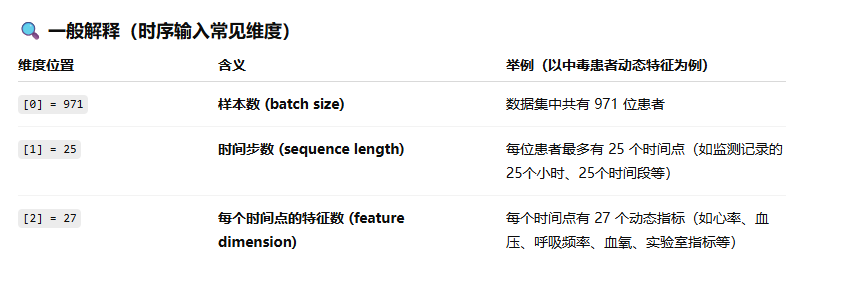

## Step 3: Build the LSTM Model

In [6]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import TensorDataset, DataLoader
# from sklearn.model_selection import KFold
# from sklearn.metrics import roc_auc_score, average_precision_score
# import pandas as pd
# import numpy as np
# import os

# # 假设以下变量来自你前面的预处理部分：
# # X_padded: torch.Size([num_patients, seq_len, dyn_features])
# # X_static: torch.Size([num_patients, static_features])
# # y_tensor: torch.Size([num_patients, 1])

# save_path = '/home/mailiyi/Poisoning_Prediction/LSTM/predict_death/'
# os.makedirs(save_path, exist_ok=True)

# # -----------------------------
# # 定义模型
# # -----------------------------
# class LSTMWithStatic(nn.Module):
#     def __init__(self, input_dim, static_dim, hidden_dim, output_dim=1):
#         super().__init__()
#         self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
#         self.fc = nn.Sequential(
#             nn.Linear(hidden_dim + static_dim, 64),
#             nn.ReLU(),
#             nn.Linear(64, output_dim),
#             nn.Sigmoid()
#         )

#     def forward(self, x_seq, x_static):
#         _, (h_n, _) = self.lstm(x_seq)
#         h_last = h_n.squeeze(0)
#         combined = torch.cat([h_last, x_static], dim=1)
#         out = self.fc(combined)
#         return out


# # -----------------------------
# # 超参数
# # -----------------------------
# n_splits = 5
# num_epochs = 30
# batch_size = 16
# lr = 1e-3
# weight_decay = 1e-4  # L2正则

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # -----------------------------
# # 五折交叉验证
# # -----------------------------
# kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
# auroc_list, auprc_list = [], []

# for fold, (train_idx, test_idx) in enumerate(kf.split(X_padded)):
#     print(f"\n===== Fold {fold+1}/{n_splits} =====")

#     # 数据划分
#     X_train_seq, X_test_seq = X_padded[train_idx], X_padded[test_idx]
#     X_train_static, X_test_static = X_static[train_idx], X_static[test_idx]
#     y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]

#     # 封装为 DataLoader
#     train_dataset = TensorDataset(X_train_seq, X_train_static, y_train)
#     test_dataset = TensorDataset(X_test_seq, X_test_static, y_test)
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#     # 初始化模型
#     model = LSTMWithStatic(
#         input_dim=X_padded.shape[2],
#         static_dim=X_static.shape[1],
#         hidden_dim=64
#     ).to(device)

#     criterion = nn.BCELoss()
#     optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

#     # -----------------------------
#     # 训练
#     # -----------------------------
#     model.train()
#     for epoch in range(num_epochs):
#         total_loss = 0
#         for batch_seq, batch_static, batch_y in train_loader:
#             batch_seq, batch_static, batch_y = (
#                 batch_seq.to(device),
#                 batch_static.to(device),
#                 batch_y.to(device)
#             )

#             optimizer.zero_grad()
#             outputs = model(batch_seq, batch_static)
#             loss = criterion(outputs, batch_y)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
#         if (epoch+1) % 5 == 0:
#             print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {total_loss/len(train_loader):.4f}")

#     # -----------------------------
#     # 测试与结果保存
#     # -----------------------------
#     model.eval()
#     y_true, y_pred = [], []
#     with torch.no_grad():
#         for batch_seq, batch_static, batch_y in test_loader:
#             batch_seq, batch_static = batch_seq.to(device), batch_static.to(device)
#             outputs = model(batch_seq, batch_static).cpu().numpy().flatten()
#             y_true.extend(batch_y.numpy().reshape(-1))
#             y_pred.extend(outputs)

#     y_true = np.array(y_true).reshape(-1)
#     y_pred = np.array(y_pred).reshape(-1)

#     # 保存结果
#     result_df = pd.DataFrame({
#         "y_test": y_true,
#         "y_pred": y_pred
#     })
#     result_df.to_csv(save_path + f"fold_{fold+1}_results.csv", index=False)


#     # 计算指标
#     auroc = roc_auc_score(y_true, y_pred)
#     auprc = average_precision_score(y_true, y_pred)
#     auroc_list.append(auroc)
#     auprc_list.append(auprc)

#     print(f"Fold {fold+1} AUROC: {auroc:.4f}, AUPRC: {auprc:.4f}")

# # -----------------------------
# # 汇总五折结果
# # -----------------------------
# def mean_ci(data):
#     mean = np.mean(data)
#     se = np.std(data, ddof=1) / np.sqrt(len(data))
#     ci95 = 1.96 * se
#     return mean, (mean - ci95, mean + ci95)

# auroc_mean, auroc_ci = mean_ci(auroc_list)
# auprc_mean, auprc_ci = mean_ci(auprc_list)

# print("\n===== 5-Fold Cross Validation Results =====")
# print(f"AUROC: {auroc_mean:.4f} (95% CI: {auroc_ci[0]:.4f}–{auroc_ci[1]:.4f})")
# print(f"AUPRC: {auprc_mean:.4f} (95% CI: {auprc_ci[0]:.4f}–{auprc_ci[1]:.4f})")


## Step 4: Keep the parameters consistent with those of the DNN (including Early Stopping, 100 epochs, and AUROC monitoring).

## 4.1 Construct the model using five-fold cross-validation with a 20% test set.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, average_precision_score
import pandas as pd
import numpy as np
import os
import random

# ==============================================
# Fixed random seed (ensure reproducibility)
# ==============================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ==============================================
# 假设以下变量来自你前面的预处理部分：
# X_padded: torch.Size([num_patients, seq_len, dyn_features])
# X_static: torch.Size([num_patients, static_features])
# y_tensor: torch.Size([num_patients, 1])
# ==============================================

save_path = '/home/mailiyi/Poisoning_Prediction/LSTM/predict_death/'
os.makedirs(save_path, exist_ok=True)

# ==============================================
# model definition
# ==============================================
class LSTMWithStatic(nn.Module):
    def __init__(self, input_dim, static_dim, hidden_dim=128, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim + static_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
            # nn.Sigmoid()
        )

    def forward(self, x_seq, x_static):
        _, (h_n, _) = self.lstm(x_seq)
        h_last = h_n[-1]  
        combined = torch.cat([h_last, x_static], dim=1)
        out = self.fc(combined)
        return out  # logits

# ==============================================
# hyper-parameter
# ==============================================
n_splits = 5
max_epochs = 100
batch_size = 16
lr = 1e-3
weight_decay = 1e-4
patience = 8  # Early Stopping

device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# ==============================================
# 5-fold cross validation
# ==============================================
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
auroc_list, auprc_list = [], []
all_results = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_padded)):
    print(f"\n===== Fold {fold+1}/{n_splits} =====")

    X_train_seq, X_test_seq = X_padded[train_idx], X_padded[test_idx]
    X_train_static, X_test_static = X_static[train_idx], X_static[test_idx]
    y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]

    # Calculate pos_weight (when positive and negative samples are unbalanced)
    num_pos = (y_train == 1).sum().item()
    num_neg = (y_train == 0).sum().item()
    pos_weight = torch.tensor(num_neg / max(num_pos, 1), dtype=torch.float32).to(device)
    print(f"pos_weight = {pos_weight:.2f}  (neg={num_neg}, pos={num_pos})")

    # DataLoader
    train_loader = DataLoader(TensorDataset(X_train_seq, X_train_static, y_train),
                              batch_size=batch_size, shuffle=True)

    model = LSTMWithStatic(
        input_dim=X_padded.shape[2],
        static_dim=X_static.shape[1],
        hidden_dim=128
    ).to(device)

    # criterion = nn.BCELoss()
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # ← 修改
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Early Stopping parameter
    best_auroc = 0
    wait = 0
    best_model_path = os.path.join(save_path, f"fold_{fold+1}_best_model.pt")

    # ==============================================
    # training loop
    # ==============================================
    for epoch in range(max_epochs):
        model.train()
        total_loss = 0.0

        for batch_seq, batch_static, batch_y in train_loader:
            batch_seq, batch_static, batch_y = (
                batch_seq.to(device),
                batch_static.to(device),
                batch_y.to(device)
            )

            optimizer.zero_grad()
            # outputs = model(batch_seq, batch_static)
            # loss = criterion(outputs, batch_y)
            logits = model(batch_seq, batch_static)  # logits
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)

        model.eval()
        with torch.no_grad():
            # y_pred = model(X_test_seq.to(device), X_test_static.to(device)).cpu().numpy().flatten()
            logits = model(X_test_seq.to(device), X_test_static.to(device)).cpu().numpy().flatten()
            y_pred = 1 / (1 + np.exp(-logits))  # 手动 Sigmoid
            y_true = y_test.numpy().reshape(-1)
            auroc = roc_auc_score(y_true, y_pred)

        print(f"Epoch {epoch+1:03d} | Loss: {avg_loss:.4f} | Test AUROC: {auroc:.4f}")

        if auroc > best_auroc:
            best_auroc = auroc
            wait = 0
            torch.save(model.state_dict(), best_model_path)
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1} (best AUROC={best_auroc:.4f})")
                break

    # ==============================================
    # Load the best model and verify
    # ==============================================
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.eval()
    with torch.no_grad():
        # y_pred = model(X_test_seq.to(device), X_test_static.to(device)).cpu().numpy().flatten()
        logits = model(X_test_seq.to(device), X_test_static.to(device)).cpu().numpy().flatten()
        y_pred = 1 / (1 + np.exp(-logits))
        y_true = y_test.numpy().reshape(-1)

        auroc = roc_auc_score(y_true, y_pred)
        auprc = average_precision_score(y_true, y_pred)
        auroc_list.append(auroc)
        auprc_list.append(auprc)

        print(f"[Fold {fold+1}] Final AUROC: {auroc:.4f}, AUPRC: {auprc:.4f}")

        result_df = pd.DataFrame({
            "y_test": y_true,
            "y_pred": y_pred
        })
        result_df.to_csv(save_path + f"fold_{fold+1}_results.csv", index=False)
        all_results.append(result_df)

# ==============================================
# summary results
# ==============================================
def mean_ci(data):
    mean = np.mean(data)
    se = np.std(data, ddof=1) / np.sqrt(len(data))
    ci95 = 1.96 * se
    return mean, (mean - ci95, mean + ci95)

auroc_mean, auroc_ci = mean_ci(auroc_list)
auprc_mean, auprc_ci = mean_ci(auprc_list)

print("\n===== 5-Fold Cross Validation Results =====")
print(f"AUROC: {auroc_mean:.4f} (95% CI: {auroc_ci[0]:.4f}–{auroc_ci[1]:.4f})")
print(f"AUPRC: {auprc_mean:.4f} (95% CI: {auprc_ci[0]:.4f}–{auprc_ci[1]:.4f})")

# -----------------------------
# Summarize all patient results and save
# -----------------------------
all_results_df = pd.concat(all_results, axis=0).reset_index(drop=True)
all_results_path = os.path.join(save_path, "all_folds_results.csv")
all_results_df.to_csv(all_results_path, index=False)

print(f"\n✅ All discounted forecast results have been merged and saved as：{all_results_path}")


Using device: cuda

===== Fold 1/5 =====
pos_weight = 10.58  (neg=709, pos=67)
Epoch 001 | Loss: 1.2463 | Test AUROC: 0.8330
Epoch 002 | Loss: 1.1825 | Test AUROC: 0.8400
Epoch 003 | Loss: 1.1115 | Test AUROC: 0.8437
Epoch 004 | Loss: 1.0174 | Test AUROC: 0.8407
Epoch 005 | Loss: 0.9551 | Test AUROC: 0.8341
Epoch 006 | Loss: 0.9097 | Test AUROC: 0.8359
Epoch 007 | Loss: 0.8644 | Test AUROC: 0.8285
Epoch 008 | Loss: 0.8391 | Test AUROC: 0.8356
Epoch 009 | Loss: 0.8286 | Test AUROC: 0.8333
Epoch 010 | Loss: 0.7714 | Test AUROC: 0.8322
Epoch 011 | Loss: 0.7772 | Test AUROC: 0.8278
Early stopping at epoch 11 (best AUROC=0.8437)
[Fold 1] Final AUROC: 0.8437, AUPRC: 0.3463

===== Fold 2/5 =====
pos_weight = 10.26  (neg=708, pos=69)
Epoch 001 | Loss: 1.2482 | Test AUROC: 0.7148
Epoch 002 | Loss: 1.1710 | Test AUROC: 0.7875
Epoch 003 | Loss: 1.0781 | Test AUROC: 0.8092
Epoch 004 | Loss: 1.0009 | Test AUROC: 0.8202
Epoch 005 | Loss: 0.9688 | Test AUROC: 0.8351
Epoch 006 | Loss: 0.9172 | Test AU

## 4.2 Build model: 10% cross validation, 10% validation set, 10% test set

In [ ]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
import pandas as pd
import numpy as np
import os
import random

# ==============================================
# Fixed random seed (ensure reproducibility)
# ==============================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ==============================================
# Suppose the following variables come from the preprocessing section before you:
# X_padded: torch.Size([num_patients, seq_len, dyn_features])
# X_static: torch.Size([num_patients, static_features])
# y_tensor: torch.Size([num_patients, 1])
# ==============================================

save_path = '/home/mailiyi/Poisoning_Prediction/LSTM/predict_death_valid_test/'
os.makedirs(save_path, exist_ok=True)

# ==============================================
# model definition
# ==============================================
class LSTMWithStatic(nn.Module):
    def __init__(self, input_dim, static_dim, hidden_dim=128, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim + static_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x_seq, x_static):
        _, (h_n, _) = self.lstm(x_seq)
        h_last = h_n[-1]  
        combined = torch.cat([h_last, x_static], dim=1)
        out = self.fc(combined)
        return out  # logits

# ==============================================
# hyper-parameter
# ==============================================
n_splits = 10
max_epochs = 100
batch_size = 16
lr = 1e-3
weight_decay = 1e-4
patience = 8  # Early Stopping

device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# ==============================================
# Ten-fold cross-validation
# ==============================================
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
auroc_list, auprc_list = [], []
all_results = []

for fold, (train_val_idx, test_idx) in enumerate(kf.split(X_padded)):
    print(f"\n===== Fold {fold+1}/{n_splits} =====")

    set_seed(42 + fold)

    # Step 1: Split test (10%) and train_val (90%)
    X_train_val_seq, X_test_seq = X_padded[train_val_idx], X_padded[test_idx]
    X_train_val_static, X_test_static = X_static[train_val_idx], X_static[test_idx]
    y_train_val, y_test = y_tensor[train_val_idx], y_tensor[test_idx]

    # Step 2: Divide 1/9 ≈ 10% from train_val as validation set
    X_train_seq, X_val_seq, X_train_static, X_val_static, y_train, y_val = train_test_split(
        X_train_val_seq, X_train_val_static, y_train_val,
        test_size=1/9, random_state=42, stratify=y_train_val
    )
    num_pos = (y_train == 1).sum().item()
    num_neg = (y_train == 0).sum().item()
    pos_weight = torch.tensor(num_neg / max(num_pos, 1), dtype=torch.float32).to(device)
    print(f"pos_weight = {pos_weight:.2f}  (neg={num_neg}, pos={num_pos})")

    # DataLoader
    train_loader = DataLoader(TensorDataset(X_train_seq, X_train_static, y_train),
                              batch_size=batch_size, shuffle=True)
    # initialization model
    model = LSTMWithStatic(
        input_dim=X_padded.shape[2],
        static_dim=X_static.shape[1],
        hidden_dim=128
    ).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_auroc = 0
    wait = 0
    best_model_path = os.path.join(save_path, f"fold_{fold+1}_best_model.pt")

    # ==============================================
    # Training loop (early stopping with validation set)
    # ==============================================
    for epoch in range(max_epochs):
        model.train()
        total_loss = 0.0

        for batch_seq, batch_static, batch_y in train_loader:
            batch_seq, batch_static, batch_y = (
                batch_seq.to(device),
                batch_static.to(device),
                batch_y.to(device)
            )

            optimizer.zero_grad()
            logits = model(batch_seq, batch_static)
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)

        # === 验证集评估 ===
        model.eval()
        with torch.no_grad():
            logits = model(X_val_seq.to(device), X_val_static.to(device)).cpu().numpy().flatten()
            y_pred = 1 / (1 + np.exp(-logits))
            y_true = y_val.numpy().reshape(-1)
            auroc_val = roc_auc_score(y_true, y_pred)

        print(f"Epoch {epoch+1:03d} | Loss: {avg_loss:.4f} | Val AUROC: {auroc_val:.4f}")

        if auroc_val > best_auroc:
            best_auroc = auroc_val
            wait = 0
            torch.save(model.state_dict(), best_model_path)
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1} (best Val AUROC={best_auroc:.4f})")
                break

    # ==============================================
    # Load the best model and evaluate it in the test set
    # ==============================================
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.eval()
    with torch.no_grad():
        logits = model(X_test_seq.to(device), X_test_static.to(device)).cpu().numpy().flatten()
        y_pred = 1 / (1 + np.exp(-logits))
        y_true = y_test.numpy().reshape(-1)

        auroc = roc_auc_score(y_true, y_pred)
        auprc = average_precision_score(y_true, y_pred)
        auroc_list.append(auroc)
        auprc_list.append(auprc)

        print(f"[Fold {fold+1}] Test AUROC: {auroc:.4f}, AUPRC: {auprc:.4f}")

        result_df = pd.DataFrame({
            "y_test": y_true,
            "y_pred": y_pred
        })
        result_df.to_csv(save_path + f"fold_{fold+1}_results.csv", index=False)
        all_results.append(result_df)

# ==============================================
# summary results
# ==============================================
def mean_ci(data):
    mean = np.mean(data)
    se = np.std(data, ddof=1) / np.sqrt(len(data))
    ci95 = 1.96 * se
    return mean, (mean - ci95, mean + ci95)

auroc_mean, auroc_ci = mean_ci(auroc_list)
auprc_mean, auprc_ci = mean_ci(auprc_list)

print("\n===== 10-Fold Cross Validation Results =====")
print(f"AUROC: {auroc_mean:.4f} (95% CI: {auroc_ci[0]:.4f}–{auroc_ci[1]:.4f})")
print(f"AUPRC: {auprc_mean:.4f} (95% CI: {auprc_ci[0]:.4f}–{auprc_ci[1]:.4f})")

# -----------------------------
# Summarize all patient results and save
# -----------------------------
all_results_df = pd.concat(all_results, axis=0).reset_index(drop=True)
all_results_path = os.path.join(save_path, "all_folds_results.csv")
all_results_df.to_csv(all_results_path, index=False)

print(f"\n✅ All discounted forecast results have been merged and saved as：{all_results_path}")


Using device: cuda

===== Fold 1/10 =====
pos_weight = 10.41  (neg=708, pos=68)
Epoch 001 | Loss: 1.2369 | Val AUROC: 0.9593
Epoch 002 | Loss: 1.1851 | Val AUROC: 0.9452
Epoch 003 | Loss: 1.0945 | Val AUROC: 0.9480
Epoch 004 | Loss: 1.0229 | Val AUROC: 0.9508
Epoch 005 | Loss: 0.9291 | Val AUROC: 0.9480
Epoch 006 | Loss: 0.9002 | Val AUROC: 0.9452
Epoch 007 | Loss: 0.8569 | Val AUROC: 0.9298
Epoch 008 | Loss: 0.8011 | Val AUROC: 0.9242
Epoch 009 | Loss: 0.8862 | Val AUROC: 0.9213
Early stopping at epoch 9 (best Val AUROC=0.9593)
[Fold 1] Test AUROC: 0.8007, AUPRC: 0.2369

===== Fold 2/10 =====
pos_weight = 10.94  (neg=711, pos=65)
Epoch 001 | Loss: 1.2533 | Val AUROC: 0.8125
Epoch 002 | Loss: 1.1855 | Val AUROC: 0.8292
Epoch 003 | Loss: 1.0885 | Val AUROC: 0.8361
Epoch 004 | Loss: 1.0197 | Val AUROC: 0.8528
Epoch 005 | Loss: 0.9614 | Val AUROC: 0.8556
Epoch 006 | Loss: 0.9305 | Val AUROC: 0.8667
Epoch 007 | Loss: 0.8639 | Val AUROC: 0.8750
Epoch 008 | Loss: 0.8395 | Val AUROC: 0.8736
E

## 4.3 Five-fold cross-validation: Further divide 1/8 of the training set into a validation set (i.e., the training set accounts for 70%, the validation set for 10%, and the test set for 20%).

## Calculate the 95% CI and mean AUC using five-fold cross-validation.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
import pandas as pd
import numpy as np
import os
import random

# ==============================================
# Fixed random seed (ensure reproducibility)
# ==============================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ==============================================
# 假设以下变量来自你前面的预处理部分：
# X_padded: torch.Size([num_patients, seq_len, dyn_features])
# X_static: torch.Size([num_patients, static_features])
# y_tensor: torch.Size([num_patients, 1])
# ==============================================

save_path = '/home/mailiyi/Poisoning_Prediction/LSTM/predict_death_valid_test_5cv/'
os.makedirs(save_path, exist_ok=True)

# ==============================================
# model definition
# ==============================================
class LSTMWithStatic(nn.Module):
    def __init__(self, input_dim, static_dim, hidden_dim=128, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim + static_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x_seq, x_static):
        _, (h_n, _) = self.lstm(x_seq)
        h_last = h_n[-1]
        combined = torch.cat([h_last, x_static], dim=1)
        out = self.fc(combined)
        return out  # logits

# ==============================================
# hyper-parameter
# ==============================================
n_splits = 10
max_epochs = 100
batch_size = 16
lr = 1e-3
weight_decay = 1e-4
patience = 8  # Early Stopping

device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# ==============================================
# Five-fold cross-validation
# ==============================================
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
auroc_list, auprc_list = [], []
all_results = []

for fold, (train_val_idx, test_idx) in enumerate(kf.split(X_padded)):
    print(f"\n===== Fold {fold+1}/{n_splits} =====")

    set_seed(42 + fold)

    # Step 1: Split test (20%) and train_val (80%)
    X_train_val_seq, X_test_seq = X_padded[train_val_idx], X_padded[test_idx]
    X_train_val_static, X_test_static = X_static[train_val_idx], X_static[test_idx]
    y_train_val, y_test = y_tensor[train_val_idx], y_tensor[test_idx]

    # Step 2: Divide 1/8 from train_val as validation set (train:val = 7:1)
    X_train_seq, X_val_seq, X_train_static, X_val_static, y_train, y_val = train_test_split(
        X_train_val_seq, X_train_val_static, y_train_val,
        test_size=1/8, random_state=42, stratify=y_train_val
    )

    # pos_weight
    num_pos = (y_train == 1).sum().item()
    num_neg = (y_train == 0).sum().item()
    pos_weight = torch.tensor(num_neg / max(num_pos, 1), dtype=torch.float32).to(device)
    print(f"pos_weight = {pos_weight:.2f}  (neg={num_neg}, pos={num_pos})")

    # DataLoader
    train_loader = DataLoader(TensorDataset(X_train_seq, X_train_static, y_train),
                              batch_size=batch_size, shuffle=True)
    model = LSTMWithStatic(
        input_dim=X_padded.shape[2],
        static_dim=X_static.shape[1],
        hidden_dim=128
    ).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_auroc = 0
    wait = 0
    best_model_path = os.path.join(save_path, f"fold_{fold+1}_best_model.pt")

    # ==============================================
    # training loop（Early Stopping）
    # ==============================================
    for epoch in range(max_epochs):
        model.train()
        total_loss = 0.0

        for batch_seq, batch_static, batch_y in train_loader:
            batch_seq, batch_static, batch_y = (
                batch_seq.to(device),
                batch_static.to(device),
                batch_y.to(device)
            )
            optimizer.zero_grad()
            logits = model(batch_seq, batch_static)
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)

        model.eval()
        with torch.no_grad():
            logits = model(X_val_seq.to(device), X_val_static.to(device)).cpu().numpy().flatten()
            y_pred = 1 / (1 + np.exp(-logits))
            y_true = y_val.numpy().reshape(-1)
            auroc_val = roc_auc_score(y_true, y_pred)

        print(f"Epoch {epoch+1:03d} | Loss: {avg_loss:.4f} | Val AUROC: {auroc_val:.4f}")

        if auroc_val > best_auroc:
            best_auroc = auroc_val
            wait = 0
            torch.save(model.state_dict(), best_model_path)
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1} (best Val AUROC={best_auroc:.4f})")
                break

    # ==============================================
    # Test Set Evaluation
    # ==============================================
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.eval()
    with torch.no_grad():
        logits = model(X_test_seq.to(device), X_test_static.to(device)).cpu().numpy().flatten()
        y_pred = 1 / (1 + np.exp(-logits))
        y_true = y_test.numpy().reshape(-1)

        auroc = roc_auc_score(y_true, y_pred)
        auprc = average_precision_score(y_true, y_pred)
        auroc_list.append(auroc)
        auprc_list.append(auprc)

        print(f"[Fold {fold+1}] Test AUROC: {auroc:.4f}, AUPRC: {auprc:.4f}")

        result_df = pd.DataFrame({
            "y_test": y_true,
            "y_pred": y_pred
        })
        result_df.to_csv(save_path + f"fold_{fold+1}_results.csv", index=False)
        all_results.append(result_df)


# ==============================================
# summary results
# ==============================================
def mean_ci(data):
    mean = np.mean(data)
    se = np.std(data, ddof=1) / np.sqrt(len(data))
    ci95 = 1.96 * se
    return mean, (mean - ci95, mean + ci95)

auroc_mean, auroc_ci = mean_ci(auroc_list)
auprc_mean, auprc_ci = mean_ci(auprc_list)

print("\n===== 5-Fold Cross Validation Results =====")
print(f"AUROC: {auroc_mean:.4f} (95% CI: {auroc_ci[0]:.4f}–{auroc_ci[1]:.4f})")
print(f"AUPRC: {auprc_mean:.4f} (95% CI: {auprc_ci[0]:.4f}–{auprc_ci[1]:.4f})")

# -----------------------------
# Summarize all patient results and save
# -----------------------------
all_results_df = pd.concat(all_results, axis=0).reset_index(drop=True)
all_results_path = os.path.join(save_path, "all_folds_results.csv")
all_results_df.to_csv(all_results_path, index=False)

print(f"\n✅ All discounted forecast results have been merged and saved as：{all_results_path}")


Using device: cuda

===== Fold 1/5 =====
pos_weight = 10.51  (neg=620, pos=59)
Epoch 001 | Loss: 1.2672 | Val AUROC: 0.8132
Epoch 002 | Loss: 1.1862 | Val AUROC: 0.8455
Epoch 003 | Loss: 1.1357 | Val AUROC: 0.8610
Epoch 004 | Loss: 1.0180 | Val AUROC: 0.8371
Epoch 005 | Loss: 0.9424 | Val AUROC: 0.8385
Epoch 006 | Loss: 0.9128 | Val AUROC: 0.8357
Epoch 007 | Loss: 0.8410 | Val AUROC: 0.8244
Epoch 008 | Loss: 0.7886 | Val AUROC: 0.8230
Epoch 009 | Loss: 0.7985 | Val AUROC: 0.8272
Epoch 010 | Loss: 0.7802 | Val AUROC: 0.8174
Epoch 011 | Loss: 0.7577 | Val AUROC: 0.8160
Early stopping at epoch 11 (best Val AUROC=0.8610)
[Fold 1] Test AUROC: 0.8307, AUPRC: 0.3427

===== Fold 2/5 =====
pos_weight = 10.32  (neg=619, pos=60)
Epoch 001 | Loss: 1.2562 | Val AUROC: 0.8452
Epoch 002 | Loss: 1.1829 | Val AUROC: 0.8889
Epoch 003 | Loss: 1.1276 | Val AUROC: 0.9051
Epoch 004 | Loss: 1.0637 | Val AUROC: 0.9251
Epoch 005 | Loss: 1.0263 | Val AUROC: 0.9151
Epoch 006 | Loss: 0.9403 | Val AUROC: 0.9201
Ep

## 4.3.2. bootstrap approach to calculate 95% confidence intervals for AUROC and AUPRC

In [ ]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
import pandas as pd
import numpy as np
import os
import random

# ==============================================
# Fixed random seed (ensure reproducibility)
# ==============================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ==============================================
# Assume the following variables from the previous preprocessing section:
# X_padded: torch.Size([num_patients, seq_len, dyn_features])
# X_static: torch.Size([num_patients, static_features])
# y_tensor: torch.Size([num_patients, 1])
# ==============================================

save_path = '/home/mailiyi/Poisoning_Prediction/LSTM/predict_death_valid_test_5cv/'
os.makedirs(save_path, exist_ok=True)

# ==============================================
# model definition
# ==============================================
class LSTMWithStatic(nn.Module):
    def __init__(self, input_dim, static_dim, hidden_dim=128, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim + static_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x_seq, x_static):
        _, (h_n, _) = self.lstm(x_seq)
        h_last = h_n[-1]  # Take the last hidden state
        combined = torch.cat([h_last, x_static], dim=1)
        out = self.fc(combined)
        return out  # logits output

# ==============================================
# bootstrap function
# ==============================================
def bootstrap_metric_ci(y_true, y_pred, metric_fn, n_bootstrap=2000, seed=42):
    rng = np.random.RandomState(seed)
    scores = []
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    for _ in range(n_bootstrap):
        idx = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[idx])) < 2:
            continue
        scores.append(metric_fn(y_true[idx], y_pred[idx]))
    return np.mean(scores), np.percentile(scores, 2.5), np.percentile(scores, 97.5)

# ==============================================
# five-fold cross-validation
# ==============================================
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
all_results = []

max_epochs = 100
batch_size = 16
lr = 1e-3
weight_decay = 1e-4
patience = 8

device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

for fold, (train_val_idx, test_idx) in enumerate(kf.split(X_padded)):
    print(f"\n===== Fold {fold+1}/{n_splits} =====")
    set_seed(42 + fold)

    # Step 1: Split test (20%) and train_val (80%)
    X_train_val_seq, X_test_seq = X_padded[train_val_idx], X_padded[test_idx]
    X_train_val_static, X_test_static = X_static[train_val_idx], X_static[test_idx]
    y_train_val, y_test = y_tensor[train_val_idx], y_tensor[test_idx]

    # Step 2: Split Validation Set
    X_train_seq, X_val_seq, X_train_static, X_val_static, y_train, y_val = train_test_split(
        X_train_val_seq, X_train_val_static, y_train_val,
        test_size=1/8, random_state=42, stratify=y_train_val
    )

    # calculate pos_weight
    num_pos = (y_train == 1).sum().item()
    num_neg = (y_train == 0).sum().item()
    pos_weight = torch.tensor(num_neg / max(num_pos,1), dtype=torch.float32).to(device)
    print(f"pos_weight = {pos_weight:.2f}  (neg={num_neg}, pos={num_pos})")

    # DataLoader
    train_loader = DataLoader(TensorDataset(X_train_seq, X_train_static, y_train),
                              batch_size=batch_size, shuffle=True)

    # initialization model
    model = LSTMWithStatic(
        input_dim=X_padded.shape[2],
        static_dim=X_static.shape[1],
        hidden_dim=128
    ).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_auroc = 0
    wait = 0
    best_model_path = os.path.join(save_path, f"fold_{fold+1}_best_model.pt")

    # ==============================================
    # training loop
    # ==============================================
    for epoch in range(max_epochs):
        model.train()
        total_loss = 0.0
        for batch_seq, batch_static, batch_y in train_loader:
            batch_seq, batch_static, batch_y = batch_seq.to(device), batch_static.to(device), batch_y.to(device)
            optimizer.zero_grad()
            logits = model(batch_seq, batch_static)
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)

        # validation set
        model.eval()
        with torch.no_grad():
            logits = model(X_val_seq.to(device), X_val_static.to(device)).cpu().numpy().flatten()
            y_pred = 1 / (1 + np.exp(-logits))
            y_true = y_val.numpy().reshape(-1)
            auroc_val = roc_auc_score(y_true, y_pred)

        print(f"Epoch {epoch+1:03d} | Loss: {avg_loss:.4f} | Val AUROC: {auroc_val:.4f}")

        if auroc_val > best_auroc:
            best_auroc = auroc_val
            wait = 0
            torch.save(model.state_dict(), best_model_path)
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1} (best Val AUROC={best_auroc:.4f})")
                break

    # ==============================================
    # Test set prediction, save all patients
    # ==============================================
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.eval()
    with torch.no_grad():
        logits = model(X_test_seq.to(device), X_test_static.to(device)).cpu().numpy().flatten()
        y_pred = 1 / (1 + np.exp(-logits))
        y_true = y_test.numpy().reshape(-1)
        result_df = pd.DataFrame({"y_test": y_true, "y_pred": y_pred})
        result_df.to_csv(save_path + f"fold_{fold+1}_results.csv", index=False)
        all_results.append(result_df)

# ==============================================
# Summarize all discount forecast results
# ==============================================
all_results_df = pd.concat(all_results, axis=0).reset_index(drop=True)
y_all_true = all_results_df["y_test"].values
y_all_pred = all_results_df["y_pred"].values

mean_auroc, auc_lower, auc_upper = bootstrap_metric_ci(y_all_true, y_all_pred, roc_auc_score)
mean_auprc, auprc_lower, auprc_upper = bootstrap_metric_ci(y_all_true, y_all_pred, average_precision_score)

print("\n===== 5-Fold Cross Validation Results (Bootstrap) =====")
print(f"AUROC: Mean = {mean_auroc:.4f}, 95% CI = ({auc_lower:.4f}–{auc_upper:.4f})")
print(f"AUPRC: Mean = {mean_auprc:.4f}, 95% CI = ({auprc_lower:.4f}–{auprc_upper:.4f})")

all_results_path = os.path.join(save_path, "all_folds_results.csv")
all_results_df.to_csv(all_results_path, index=False)
print(f"\n✅ All discounted forecast results have been merged and saved as：{all_results_path}")


## 4.3.3. reduce overfitting

In [ ]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
import pandas as pd
import numpy as np
import os
import random

# ===================== fixed random seed =====================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# ===================== save path =====================
save_path = '/home/mailiyi/Poisoning_Prediction/LSTM/predict_death_valid_test_5cv/'
os.makedirs(save_path, exist_ok=True)

# ===================== model definition =====================
class LSTMWithStatic(nn.Module):
    def __init__(self, input_dim, static_dim, hidden_dim=64, num_layers=2, dropout=0.5):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim + static_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )
    def forward(self, x_seq, x_static):
        _, (h_n, _) = self.lstm(x_seq)
        h_last = h_n[-1]
        combined = torch.cat([h_last, x_static], dim=1)
        out = self.fc(combined)
        return out

# ===================== Bootstrap function =====================
def bootstrap_metric_ci(y_true, y_pred, metric_fn, n_bootstrap=2000, seed=42):
    rng = np.random.RandomState(seed)
    scores = []
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    for _ in range(n_bootstrap):
        idx = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[idx])) < 2:
            continue
        scores.append(metric_fn(y_true[idx], y_pred[idx]))
    return np.mean(scores), np.percentile(scores, 2.5), np.percentile(scores, 97.5)

# ===================== five-fold cross-validation =====================
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
all_results = []

max_epochs = 100
batch_size = 16
lr = 5e-4
weight_decay = 5e-4
patience = 12

device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

for fold, (train_val_idx, test_idx) in enumerate(kf.split(X_padded)):
    print(f"\n===== Fold {fold+1}/{n_splits} =====")
    set_seed(42 + fold)

    X_train_val_seq, X_test_seq = X_padded[train_val_idx], X_padded[test_idx]
    X_train_val_static, X_test_static = X_static[train_val_idx], X_static[test_idx]
    y_train_val, y_test = y_tensor[train_val_idx], y_tensor[test_idx]

    X_train_seq, X_val_seq, X_train_static, X_val_static, y_train, y_val = train_test_split(
        X_train_val_seq, X_train_val_static, y_train_val,
        test_size=1/8, random_state=42, stratify=y_train_val
    )

    # pos_weight
    num_pos = (y_train == 1).sum().item()
    num_neg = (y_train == 0).sum().item()
    pos_weight = torch.tensor(num_neg / max(num_pos,1), dtype=torch.float32).to(device)
    print(f"pos_weight = {pos_weight:.2f}  (neg={num_neg}, pos={num_pos})")

    train_loader = DataLoader(TensorDataset(X_train_seq, X_train_static, y_train),
                              batch_size=batch_size, shuffle=True)

    model = LSTMWithStatic(
        input_dim=X_padded.shape[2],
        static_dim=X_static.shape[1],
        hidden_dim=64,  # 调整隐藏维度
        dropout=0.5     # 增加 dropout
    ).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_auroc = 0
    wait = 0
    best_model_path = os.path.join(save_path, f"fold_{fold+1}_best_model.pt")

    for epoch in range(max_epochs):
        model.train()
        total_loss = 0.0
        for batch_seq, batch_static, batch_y in train_loader:
            batch_seq, batch_static, batch_y = batch_seq.to(device), batch_static.to(device), batch_y.to(device)
            optimizer.zero_grad()
            logits = model(batch_seq, batch_static)
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)

        # 验证
        model.eval()
        with torch.no_grad():
            logits = model(X_val_seq.to(device), X_val_static.to(device)).cpu().numpy().flatten()
            y_pred = 1 / (1 + np.exp(-logits))
            y_true = y_val.numpy().reshape(-1)
            auroc_val = roc_auc_score(y_true, y_pred)

        print(f"Epoch {epoch+1:03d} | Loss: {avg_loss:.4f} | Val AUROC: {auroc_val:.4f}")

        if auroc_val > best_auroc:
            best_auroc = auroc_val
            wait = 0
            torch.save(model.state_dict(), best_model_path)
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1} (best Val AUROC={best_auroc:.4f})")
                break

    # 测试集预测
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.eval()
    with torch.no_grad():
        logits = model(X_test_seq.to(device), X_test_static.to(device)).cpu().numpy().flatten()
        y_pred = 1 / (1 + np.exp(-logits))
        y_true = y_test.numpy().reshape(-1)
        result_df = pd.DataFrame({"y_test": y_true, "y_pred": y_pred})
        result_df.to_csv(save_path + f"fold_{fold+1}_results.csv", index=False)
        all_results.append(result_df)

# ===================== summary results =====================
all_results_df = pd.concat(all_results, axis=0).reset_index(drop=True)
y_all_true = all_results_df["y_test"].values
y_all_pred = all_results_df["y_pred"].values

mean_auroc, auc_lower, auc_upper = bootstrap_metric_ci(y_all_true, y_all_pred, roc_auc_score)
mean_auprc, auprc_lower, auprc_upper = bootstrap_metric_ci(y_all_true, y_all_pred, average_precision_score)

print("\n===== 5-Fold Cross Validation Results (Bootstrap) =====")
print(f"AUROC: Mean = {mean_auroc:.4f}, 95% CI = ({auc_lower:.4f}–{auc_upper:.4f})")
print(f"AUPRC: Mean = {mean_auprc:.4f}, 95% CI = ({auprc_lower:.4f}–{auprc_upper:.4f})")

all_results_path = os.path.join(save_path, "all_folds_results.csv")
all_results_df.to_csv(all_results_path, index=False)
print(f"\n✅ 5-Fold Cross Validation Results as：{all_results_path}")


## 4.3.4. Try random seed

In [ ]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
import pandas as pd
import numpy as np
import os
import random

# ===================== fixed random seed function =====================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ===================== model definition =====================
class LSTMWithStatic(nn.Module):
    def __init__(self, input_dim, static_dim, hidden_dim=64, num_layers=2, dropout=0.5):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim + static_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )
    def forward(self, x_seq, x_static):
        _, (h_n, _) = self.lstm(x_seq)
        h_last = h_n[-1]
        combined = torch.cat([h_last, x_static], dim=1)
        out = self.fc(combined)
        return out

# ===================== Bootstrap function =====================
def bootstrap_metric_ci(y_true, y_pred, metric_fn, n_bootstrap=2000, seed=42):
    rng = np.random.RandomState(seed)
    scores = []
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    for _ in range(n_bootstrap):
        idx = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[idx])) < 2:
            continue
        scores.append(metric_fn(y_true[idx], y_pred[idx]))
    return np.mean(scores), np.percentile(scores, 2.5), np.percentile(scores, 97.5)

# ===================== main training cycle =====================
def train_until_target_auc(X_padded, X_static, y_tensor, save_path, target_auc=0.80):
    os.makedirs(save_path, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else
                          "mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")

    tried_seeds = []
    while True:
        seed = random.randint(0, 9999)
        if seed in tried_seeds:
            continue
        tried_seeds.append(seed)
        print(f"\n================== Try random seeds {seed} ==================")
        set_seed(seed)

        kf = KFold(n_splits=5, shuffle=True, random_state=seed)
        all_results = []

        max_epochs = 100
        batch_size = 16
        lr = 5e-4
        weight_decay = 5e-4
        patience = 12

        for fold, (train_val_idx, test_idx) in enumerate(kf.split(X_padded)):
            print(f"\n===== Fold {fold+1}/5 =====")

            X_train_val_seq, X_test_seq = X_padded[train_val_idx], X_padded[test_idx]
            X_train_val_static, X_test_static = X_static[train_val_idx], X_static[test_idx]
            y_train_val, y_test = y_tensor[train_val_idx], y_tensor[test_idx]

            X_train_seq, X_val_seq, X_train_static, X_val_static, y_train, y_val = train_test_split(
                X_train_val_seq, X_train_val_static, y_train_val,
                test_size=1/8, random_state=seed, stratify=y_train_val
            )

            # pos_weight
            num_pos = (y_train == 1).sum().item()
            num_neg = (y_train == 0).sum().item()
            pos_weight = torch.tensor(num_neg / max(num_pos,1), dtype=torch.float32).to(device)
            print(f"pos_weight = {pos_weight:.2f}  (neg={num_neg}, pos={num_pos})")

            train_loader = DataLoader(TensorDataset(X_train_seq, X_train_static, y_train),
                                      batch_size=batch_size, shuffle=True)

            model = LSTMWithStatic(
                input_dim=X_padded.shape[2],
                static_dim=X_static.shape[1],
                hidden_dim=64,
                dropout=0.5
            ).to(device)

            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

            best_auroc = 0
            wait = 0
            best_model_path = os.path.join(save_path, f"seed_{seed}_fold_{fold+1}_best.pt")

            for epoch in range(max_epochs):
                model.train()
                total_loss = 0.0
                for batch_seq, batch_static, batch_y in train_loader:
                    batch_seq, batch_static, batch_y = batch_seq.to(device), batch_static.to(device), batch_y.to(device)
                    optimizer.zero_grad()
                    logits = model(batch_seq, batch_static)
                    loss = criterion(logits, batch_y)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()
                avg_loss = total_loss / len(train_loader)

                # verification
                model.eval()
                with torch.no_grad():
                    logits = model(X_val_seq.to(device), X_val_static.to(device)).cpu().numpy().flatten()
                    y_pred = 1 / (1 + np.exp(-logits))
                    y_true = y_val.numpy().reshape(-1)
                    auroc_val = roc_auc_score(y_true, y_pred)

                print(f"Epoch {epoch+1:03d} | Loss: {avg_loss:.4f} | Val AUROC: {auroc_val:.4f}")

                if auroc_val > best_auroc:
                    best_auroc = auroc_val
                    wait = 0
                    torch.save(model.state_dict(), best_model_path)
                else:
                    wait += 1
                    if wait >= patience:
                        print(f"Early stopping at epoch {epoch+1} (best Val AUROC={best_auroc:.4f})")
                        break

            # test set prediction
            model.load_state_dict(torch.load(best_model_path, map_location=device))
            model.eval()
            with torch.no_grad():
                logits = model(X_test_seq.to(device), X_test_static.to(device)).cpu().numpy().flatten()
                y_pred = 1 / (1 + np.exp(-logits))
                y_true = y_test.numpy().reshape(-1)
                result_df = pd.DataFrame({"seed": seed, "fold": fold+1, "y_test": y_true, "y_pred": y_pred})
                result_df.to_csv(os.path.join(save_path, f"seed_{seed}_fold_{fold+1}_results.csv"), index=False)
                all_results.append(result_df)

        # Summarize all folds
        all_results_df = pd.concat(all_results, axis=0).reset_index(drop=True)
        y_all_true = all_results_df["y_test"].values
        y_all_pred = all_results_df["y_pred"].values

        mean_auroc, auc_lower, auc_upper = bootstrap_metric_ci(y_all_true, y_all_pred, roc_auc_score)
        mean_auprc, auprc_lower, auprc_upper = bootstrap_metric_ci(y_all_true, y_all_pred, average_precision_score)

        print(f"\n===== Bootstrap Results for Seed {seed} =====")
        print(f"AUROC: {mean_auroc:.4f} (95% CI {auc_lower:.4f}–{auc_upper:.4f})")
        print(f"AUPRC: {mean_auprc:.4f} (95% CI {auprc_lower:.4f}–{auprc_upper:.4f})")

        if mean_auroc >= target_auc:
            print(f"\n🎯 Reach target AUROC ≥ {target_auc}, stop cycle with random seed {seed}!")
            all_results_df.to_csv(os.path.join(save_path, f"seed_{seed}_all_results.csv"), index=False)
            break

# ===================== Call example =====================
save_path = '/home/mailiyi/Poisoning_Prediction/LSTM/predict_death_valid_test_5cv/'
train_until_target_auc(X_padded, X_static, y_tensor, save_path, target_auc=0.80)


## finally used 5 CV (70% train, 10% valid, 20% test)

## Do not use pos_weight

In [ ]:
import torch  
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
import pandas as pd
import numpy as np
import os
import random

# ===================== fixed random seed =====================
def set_seed(seed=1251):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed fixed as {seed}")

set_seed(1251)

# ===================== model definition =====================
class LSTMWithStatic(nn.Module):
    def __init__(self, input_dim, static_dim, hidden_dim=64, num_layers=2, dropout=0.5):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim + static_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )
    def forward(self, x_seq, x_static):
        _, (h_n, _) = self.lstm(x_seq)
        h_last = h_n[-1]
        combined = torch.cat([h_last, x_static], dim=1)
        out = self.fc(combined)
        return out  # logits

# ===================== Bootstrap function =====================
def bootstrap_metric_ci(y_true, y_pred, metric_fn, n_bootstrap=2000, seed=1251):
    rng = np.random.RandomState(seed)
    scores = []
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    for _ in range(n_bootstrap):
        idx = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[idx])) < 2:
            continue
        scores.append(metric_fn(y_true[idx], y_pred[idx]))
    return np.mean(scores), np.percentile(scores, 2.5), np.percentile(scores, 97.5)

# ===================== master training function =====================
def train_lstm_5fold(X_padded, X_static, y_tensor, save_path, target_auc=0.80):
    os.makedirs(save_path, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else
                          "mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")

    seed = 1251
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    all_results = []

    max_epochs = 100
    batch_size = 16
    lr = 5e-4
    weight_decay = 5e-4
    patience = 12

    for fold, (train_val_idx, test_idx) in enumerate(kf.split(X_padded)):
        print(f"\n===== Fold {fold+1}/5 =====")

        X_train_val_seq, X_test_seq = X_padded[train_val_idx], X_padded[test_idx]
        X_train_val_static, X_test_static = X_static[train_val_idx], X_static[test_idx]
        y_train_val, y_test = y_tensor[train_val_idx], y_tensor[test_idx]

        X_train_seq, X_val_seq, X_train_static, X_val_static, y_train, y_val = train_test_split(
            X_train_val_seq, X_train_val_static, y_train_val,
            test_size=1/8, random_state=seed, stratify=y_train_val
        )

        train_loader = DataLoader(TensorDataset(X_train_seq, X_train_static, y_train),
                                  batch_size=batch_size, shuffle=True)

        model = LSTMWithStatic(
            input_dim=X_padded.shape[2],
            static_dim=X_static.shape[1],
            hidden_dim=64,
            dropout=0.5
        ).to(device)

        # ===== Do not use pos_weight =====
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        best_auroc = 0
        wait = 0
        best_model_path = os.path.join(save_path, f"fold_{fold+1}_best.pt")

        for epoch in range(max_epochs):
            model.train()
            total_loss = 0.0
            for batch_seq, batch_static, batch_y in train_loader:
                batch_seq, batch_static, batch_y = batch_seq.to(device), batch_static.to(device), batch_y.to(device)
                optimizer.zero_grad()
                logits = model(batch_seq, batch_static)
                loss = criterion(logits, batch_y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(train_loader)

            # verification
            model.eval()
            with torch.no_grad():
                logits = model(X_val_seq.to(device), X_val_static.to(device)).cpu().numpy().flatten()
                y_pred = 1 / (1 + np.exp(-logits))
                y_true = y_val.numpy().reshape(-1)
                auroc_val = roc_auc_score(y_true, y_pred)

            print(f"Epoch {epoch+1:03d} | Loss: {avg_loss:.4f} | Val AUROC: {auroc_val:.4f}")

            if auroc_val > best_auroc:
                best_auroc = auroc_val
                wait = 0
                torch.save(model.state_dict(), best_model_path)
            else:
                wait += 1
                if wait >= patience:
                    print(f"Early stopping at epoch {epoch+1} (best Val AUROC={best_auroc:.4f})")
                    break

        # test set prediction
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        model.eval()
        with torch.no_grad():
            logits = model(X_test_seq.to(device), X_test_static.to(device)).cpu().numpy().flatten()
            y_pred = 1 / (1 + np.exp(-logits))
            y_true = y_test.numpy().reshape(-1)
            result_df = pd.DataFrame({"fold": fold+1, "y_test": y_true, "y_pred": y_pred})
            result_df.to_csv(os.path.join(save_path, f"fold_{fold+1}_results.csv"), index=False)
            all_results.append(result_df)

    # Summarize all folds
    all_results_df = pd.concat(all_results, axis=0).reset_index(drop=True)
    y_all_true = all_results_df["y_test"].values
    y_all_pred = all_results_df["y_pred"].values

    mean_auroc, auc_lower, auc_upper = bootstrap_metric_ci(y_all_true, y_all_pred, roc_auc_score)
    mean_auprc, auprc_lower, auprc_upper = bootstrap_metric_ci(y_all_true, y_all_pred, average_precision_score)

    print(f"\n===== five-fold LSTM Bootstrap result =====")
    print(f"AUROC: {mean_auroc:.4f} (95% CI {auc_lower:.4f}–{auc_upper:.4f})")
    print(f"AUPRC: {mean_auprc:.4f} (95% CI {auprc_lower:.4f}–{auprc_upper:.4f})")

    all_results_df.to_csv(os.path.join(save_path, f"all_folds_results.csv"), index=False)
    print(f"\n✅ All discount forecast results saved to {save_path}")

# ===================== Call example =====================
save_path = '/home/mailiyi/Poisoning_Prediction/LSTM/predict_death_calibration/'
train_lstm_5fold(X_padded, X_static, y_tensor, save_path, target_auc=0.80)
